# Notebook generating plots for NeurIPS paper

### Imports

In [6]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import nistats
import scipy
import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nilearn.regions import RegionExtractor
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

In [7]:
import warnings
warnings.simplefilter(action='ignore')

In [8]:
from logger import Logger
from utils import read_yaml, check_folder, fetch_masker, possible_subjects_id, get_subject_name
import reporting
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Defining variables

In [9]:
language = 'english'

In [60]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"
SMOOTHED_MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/smoothed_global_masker_{language}"

Fetch a masker fitted on all subjects data and the following characterisctics:
- detrend: true
- dtype: null
- high_pass: null
- low_pass: null
- mask_strategy: background
- memory_level: 0
- n_jobs: 1
- smoothing_fwhm: null # try with 6 next time
- standardize: true
- t_r: null
- verbose: 0

In [61]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

In [75]:
global_masker_50 = reporting.fetch_masker(f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_80 = reporting.fetch_masker(f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_80%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_90 = reporting.fetch_masker(f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_90%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)

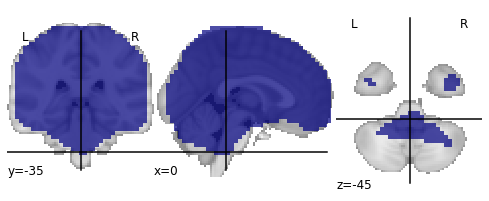

In [43]:
plotting.plot_roi(global_masker.mask_img, cut_coords=(0,-35,-45)) # 80%
plotting.show()

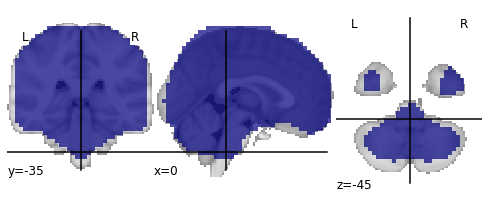

In [39]:
plotting.plot_roi(global_masker.mask_img, cut_coords=(0,-35,-45)) #50%
plotting.show()

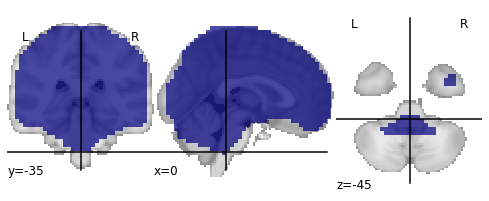

In [47]:
plotting.plot_roi(global_masker.mask_img, cut_coords=(0,-35,-45)) #90%
plotting.show()

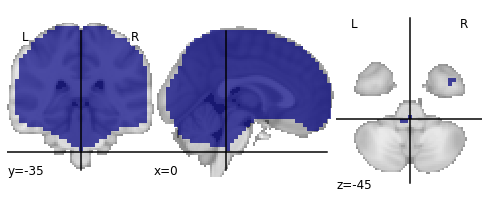

In [63]:
plotting.plot_roi(global_masker.mask_img, cut_coords=(0,-35,-45)) #95%
plotting.show()

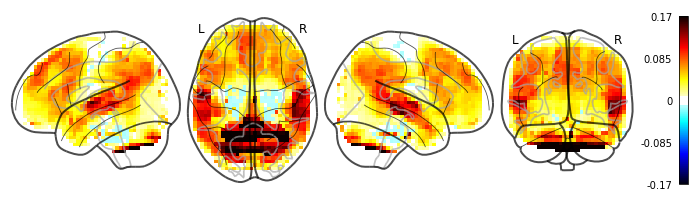

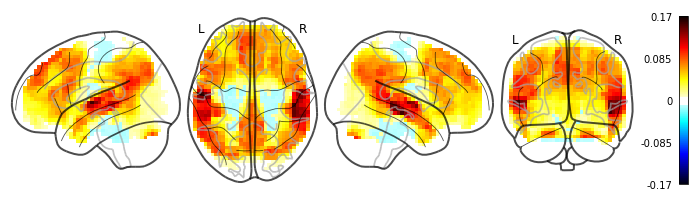

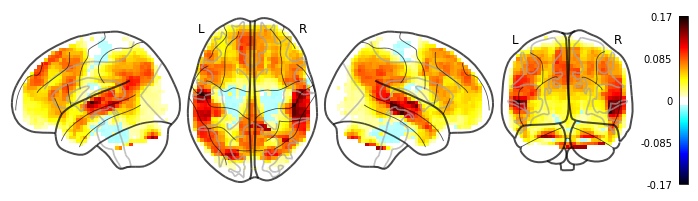

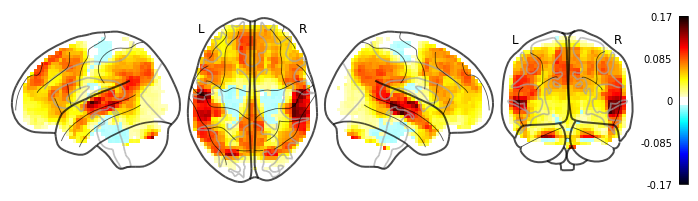

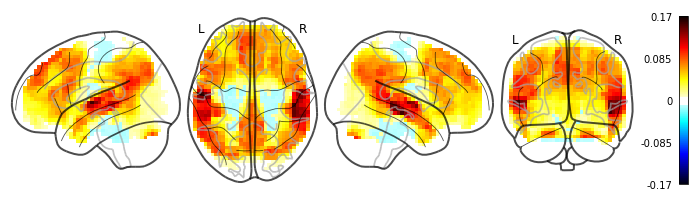

In [76]:
template = "/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/oldstuff/fastsrm/sub-0*"
paths = glob.glob(template)
data = [np.load(p) for p in paths]
data = np.array(data)
plotting.plot_glass_brain(img, colorbar=True, plot_abs=False, display_mode='lzry', vmax=0.17) 
plotting.plot_glass_brain(global_masker.inverse_transform(global_masker.transform(img)), colorbar=True, plot_abs=False, display_mode='lzry', vmax=0.17) 
plotting.plot_glass_brain(global_masker_80.inverse_transform(global_masker_80.transform(img)), colorbar=True, plot_abs=False, display_mode='lzry', vmax=0.17) 
plotting.plot_glass_brain(global_masker_90.inverse_transform(global_masker_90.transform(img)), colorbar=True, plot_abs=False, display_mode='lzry', vmax=0.17) 
plotting.plot_glass_brain(global_masker_95.inverse_transform(global_masker_95.transform(img)), colorbar=True, plot_abs=False, display_mode='lzry', vmax=0.17) 
plt.show()  

In [55]:
img = global_masker.inverse_transform(np.mean(data, axis=0))

In [8]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'
x_labels = labels[1:]

## Group level analysis

In [11]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300'
]

model_names = [
    'bert-base-cased_pre-0_1_post-0_norm-std',
    'bert-base-cased_pre-1_1_post-0_norm-std',
    'bert-base-cased_pre-2_1_post-0_norm-std',
    'bert-base-cased_pre-5_1_post-0_norm-std',
    'bert-base-cased_pre-10_1_post-0_norm-std',
    'bert-base-cased_pre-15_1_post-0_norm-std',
    'bert-base-cased_pre-20_1_post-0_norm-std',
    'bert-base-cased_pre-0_1_post-0_norm-inf',
    'bert-base-cased_pre-1_1_post-0_norm-inf',
    'bert-base-cased_pre-2_1_post-0_norm-inf',
    'bert-base-cased_pre-5_1_post-0_norm-inf',
    'bert-base-cased_pre-10_1_post-0_norm-inf',
    'bert-base-cased_pre-15_1_post-0_norm-inf',
    'bert-base-cased_pre-20_1_post-0_norm-inf',
    'bert-base-cased_pre-0_1_post-0_norm-5',
    'bert-base-cased_pre-1_1_post-0_norm-5',
    'bert-base-cased_pre-2_1_post-0_norm-5',
    'bert-base-cased_pre-5_1_post-0_norm-5',
    'bert-base-cased_pre-10_1_post-0_norm-5',
    'bert-base-cased_pre-15_1_post-0_norm-5',
    'bert-base-cased_pre-20_1_post-0_norm-5',
    'bert-base-cased_pre-0_1_post-0_norm-3',
    'bert-base-cased_pre-1_1_post-0_norm-3',
    'bert-base-cased_pre-2_1_post-0_norm-3',
    'bert-base-cased_pre-5_1_post-0_norm-3',
    'bert-base-cased_pre-10_1_post-0_norm-3',
    'bert-base-cased_pre-15_1_post-0_norm-3',
    'bert-base-cased_pre-20_1_post-0_norm-3',
    'bert-base-cased_pre-0_1_post-0_norm-2',
    'bert-base-cased_pre-1_1_post-0_norm-2',
    'bert-base-cased_pre-2_1_post-0_norm-2',
    'bert-base-cased_pre-5_1_post-0_norm-2',
    'bert-base-cased_pre-10_1_post-0_norm-2',
    'bert-base-cased_pre-15_1_post-0_norm-2',
    'bert-base-cased_pre-20_1_post-0_norm-2'
]


for index, model in enumerate(model_names):
    model_names[index] = model.replace('bert-base-cased', 'gpt2').replace('post-0_', '')
model_names += [
    'bert-base-cased_pre-0_1_post-0_norm-None',
    'bert-base-cased_pre-1_1_post-0_norm-None',
    'bert-base-cased_pre-2_1_post-0_norm-None',
    'bert-base-cased_pre-5_1_post-0_norm-None',
    'bert-base-cased_pre-7_1_post-0_norm-None',
    'bert-base-cased_pre-10_1_post-0_norm-None',
    'bert-base-cased_pre-15_1_post-0_norm-None',
    'bert-base-cased_pre-20_1_post-0_norm-None',
] * 5
data_compression = ['pca'] * 80
ncomponents = [300] * 80
order = ['std'] * 7 + ['np.inf'] * 7 + ['5'] * 7 + ['3'] * 7 + ['2'] * 7 + ['std'] * 8 + ['np.inf'] * 8 + ['5'] * 8 + ['3'] * 8 + ['2'] * 8

In [36]:
for index, model in enumerate(model_names):
    model_names[index] = '{}_norm-{}_{}_hidden-all-layers_pca_300'.format(model, order[index], 'subject').replace('subject', '{}').replace('np.', '')

In [11]:
model_names = [
    'roberta-base_pre-15_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-9_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-3_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'gpt2_pre-0_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-0_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-2_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-25_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_old_scaled_{}_all-hidden-layers_pca_300',
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_{}_all-hidden-layers_pca_300', 
    'bert-base-cased_old_{}_all-hidden-layers_pca_300',
    'BF_rms_{}',
    'BF_log_frequency_{}',
    'BF_wordrate_{}',
    'BF_content_words_{}',
    'BF_function_words_{}',
    'BF_word_position_{}'
]

Loading data:

In [10]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-0_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-0_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-1_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-15_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-20_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-0_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-1_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-15_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-20_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-0_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-1_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-15_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-20_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-0_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-1_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-15_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-20_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-0_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-1_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-15_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-20_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',]

In [11]:
data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)

  2%|▏         | 1/51 [00:00<00:13,  3.79it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:10,  4.55it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  6.14it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:06,  6.29it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.77it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  6.89it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:06,  6.18it/s]

sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:02<00:07,  5.23it/s]

sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:06,  5.16it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:03<00:06,  5.08it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:03<00:06,  5.19it/s]

sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:03<00:06,  4.71it/s]

sub-077 - 1 - 1


 41%|████      | 21/51 [00:04<00:06,  4.41it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:04<00:05,  5.18it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:04<00:05,  4.85it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:05<00:04,  5.07it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:05<00:04,  5.47it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:05<00:03,  6.51it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:06<00:02,  6.22it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:06<00:02,  6.77it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:06<00:01,  7.09it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:06<00:01,  7.38it/s]

sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:06<00:01,  6.08it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:07<00:01,  6.88it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:07<00:00,  7.53it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:07<00:00,  6.99it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:08<00:00,  6.91it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:08<00:00,  7.09it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.02it/s]

sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:09,  4.94it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


  8%|▊         | 4/51 [00:00<00:08,  5.42it/s]

sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:08,  5.39it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:07,  5.99it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.05it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.59it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.04it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.12it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  8.19it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  7.69it/s]

sub-078 - 1 - 1


 41%|████      | 21/51 [00:03<00:05,  5.17it/s]

sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:03<00:05,  5.06it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:04,  6.24it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  6.28it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:04<00:03,  6.26it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:04<00:03,  5.76it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:05<00:02,  6.66it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:05<00:02,  5.79it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:06<00:01,  7.02it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:06<00:01,  6.42it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:06<00:01,  5.87it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:07<00:00,  6.57it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:07<00:00,  6.20it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 16.41it/s]

sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04,  9.64it/s]

sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:08,  5.65it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:10,  4.23it/s]

sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:09,  4.43it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:08,  5.18it/s]

sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:02<00:07,  5.12it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:02<00:09,  4.11it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:02<00:07,  4.74it/s]

sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:03<00:06,  5.03it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:03<00:06,  5.21it/s]

sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:03<00:06,  4.87it/s]

sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:04<00:06,  4.67it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:04<00:05,  5.26it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:04<00:04,  6.47it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:04<00:03,  7.87it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:05<00:02,  8.28it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:05<00:01,  9.67it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:05<00:01,  9.79it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:05<00:01,  9.79it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:06<00:01,  8.90it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:06<00:01,  9.17it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:06<00:00,  9.86it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:06<00:00,  7.98it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:07<00:00,  7.99it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:07<00:00,  7.66it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:07<00:00,  7.53it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.69it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.43it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.36it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.37it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  8.09it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  7.12it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  7.50it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.13it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:02, 10.47it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 11.02it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 13.39it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.42it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:01, 10.76it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  9.37it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01,  8.72it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  7.44it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  7.71it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 10.43it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 11.02it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00,  9.86it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  8.81it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04,  9.78it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.45it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.33it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.76it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.93it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.06it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 10.65it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.05it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.10it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 11.80it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 10.17it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 11.38it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 11.86it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.00it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 11.84it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 10.99it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 11.02it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 10.14it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.52it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04, 10.17it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.96it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 12.11it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 11.31it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  9.13it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  8.73it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.02it/s]

sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:03,  7.04it/s]

sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:03,  5.54it/s]

sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:03,  5.09it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:03,  5.21it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:03,  5.14it/s]

sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:03,  4.99it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:02,  6.15it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:05<00:01,  6.44it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  6.26it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:01,  6.86it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00,  6.93it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:06<00:00,  7.90it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.14it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 11.71it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.04it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  8.88it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.43it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  9.38it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.64it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03,  9.90it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 10.30it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.63it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.47it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.58it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:03,  6.01it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  6.48it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:02,  7.10it/s]

sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:02,  5.91it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  6.34it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  5.64it/s]

sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:05<00:01,  5.62it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  5.59it/s]

sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:01,  4.63it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:06<00:00,  5.43it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00,  6.30it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.10it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.25it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  7.95it/s]

sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:09,  4.65it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:07,  5.51it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  6.42it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:02<00:04,  7.10it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.83it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 -

 39%|███▉      | 20/51 [00:02<00:03,  8.75it/s]

 1
sub-078 - 1 - 1
sub-079 - 1 

 41%|████      | 21/51 [00:02<00:03,  8.41it/s]

- 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.98it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:02,  9.69it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.81it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.99it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 10.95it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  9.10it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01, 10.98it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 

 86%|████████▋ | 44/51 [00:04<00:00, 12.15it/s]

1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 16.55it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.39it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:07,  6.41it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.03it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.34it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  8.29it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.05it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.69it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:04,  8.64it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03,  8.80it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.92it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.53it/s]

sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:04,  6.63it/s]

sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:04,  6.17it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  7.01it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.10it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:04<00:01,  9.58it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01, 10.76it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:00, 11.90it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 13.53it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 12.75it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00, 13.07it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.05it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 10.52it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.21it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.47it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 10.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.40it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  6.75it/s]

sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  6.24it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  7.30it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  7.79it/s]

sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:03<00:03,  6.71it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  7.30it/s]

sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:03,  6.24it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  7.25it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.91it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  7.85it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.59it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00, 11.44it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:03, 15.72it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.47it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.53it/s]

sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:05,  7.33it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.06it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  6.81it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03,  9.03it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  9.40it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.74it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.14it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.73it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01, 11.66it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01,  9.34it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  9.67it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01, 10.19it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  8.62it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  9.37it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 10.49it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.93it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.55it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.55it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 12.34it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 10.90it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.26it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03,  8.76it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 10.15it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.44it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.35it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  8.97it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  8.59it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  7.27it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:02,  6.97it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  7.61it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  8.01it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:01,  7.72it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  8.45it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  8.54it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.35it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 11.24it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 11.62it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.71it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 10.58it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.94it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.35it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.69it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.12it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  8.41it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 10.98it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.73it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 14.14it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 14.03it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 15.16it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.44it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  7.90it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.23it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.97it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:07,  5.75it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:05,  6.76it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:04,  7.62it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03,  9.26it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  6.48it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:03<00:04,  7.02it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:03<00:04,  6.00it/s]

sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:04,  6.00it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  6.74it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:04<00:03,  6.58it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:04<00:02,  7.01it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:04<00:02,  7.44it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:01,  8.94it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01,  8.58it/s]

sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:05<00:01,  6.35it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  7.36it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:00,  8.37it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:06<00:00,  8.29it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:06<00:00,  7.90it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:06<00:00,  7.88it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.87it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.91it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  7.25it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:04,  8.56it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.38it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 11.10it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03,  9.27it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  9.86it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.79it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.40it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.76it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  9.57it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.50it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 12.20it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.68it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 12.01it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 -

 88%|████████▊ | 45/51 [00:04<00:00, 13.44it/s]

 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.59it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 12.30it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.70it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.95it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.14it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.25it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1

 25%|██▌       | 13/51 [00:01<00:03, 10.60it/s]


sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.78it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 10.84it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.89it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.72it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.53it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 10.60it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.31it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 12.02it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.39it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 11.88it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 11.34it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 11.64it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 12.24it/s]

sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.72it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.37it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.93it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.57it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.41it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 12.03it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.87it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:03,  9.93it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.09it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.61it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.28it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 13.52it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 13.16it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 13.01it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 16.96it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 15.51it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.54it/s]

sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.62it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.30it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.70it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.74it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  7.64it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  7.77it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  6.92it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.15it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  7.08it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  7.26it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:03,  8.01it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02, 10.86it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 12.42it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  9.92it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 11.66it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 10.75it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.36it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 11.78it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  8%|▊         | 4/51 [00:00<00:02, 17.26it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 15.12it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 14.02it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 15.40it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 13.75it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.68it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.03it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 12.53it/s]

sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.29it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 10.25it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 11.81it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.44it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  9.61it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01,  9.15it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00,  9.77it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  8.22it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.37it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:09,  5.22it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:07,  6.15it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.88it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:06,  7.33it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.58it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.34it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03,  9.62it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  9.29it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.19it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.36it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.03it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 15.47it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.82it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.60it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.23it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.40it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00,  7.88it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.74it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.03it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.30it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  6.83it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.14it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.44it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  7.05it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.07it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.62it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.74it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.60it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02, 10.61it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 11.75it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 11.15it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01, 10.74it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  9.29it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 10.98it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  9.25it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  8.49it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  9.77it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.03it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.46it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.46it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.11it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.91it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.25it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:01, 14.93it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 13.70it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 11.37it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  9.18it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 10.18it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 12.60it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 14.38it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.79it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 11.14it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.53it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.46it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.89it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 11.20it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 12.22it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.37it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.37it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 12.46it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.17it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  9.98it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.98it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 10.13it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.81it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.17it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:01,  9.44it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 10.07it/s]

sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  8.90it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.94it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00,  7.46it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.23it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:03, 12.68it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.23it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 13.15it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 14.61it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.46it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.54it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:03,  8.80it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.17it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.64it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.85it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 12.14it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.60it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 13.09it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 12.39it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.08it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:15,  3.23it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:10,  4.52it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:07,  6.27it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  7.37it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:05,  7.20it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.02it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  8.96it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:03,  8.28it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:05,  5.58it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:04,  6.01it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:03<00:04,  6.39it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  9.30it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.48it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01,  9.63it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 11.77it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  8.27it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00,  9.75it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:05<00:00, 11.17it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00, 10.32it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 25.99it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 16.94it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 17.14it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 14.90it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:02, 15.44it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.17it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.81it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02,  9.44it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.60it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:03,  6.59it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:02,  7.00it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  7.67it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  9.71it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.01it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 11.40it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 12.03it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 11.72it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.87it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.27it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.99it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.18it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 10.24it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 10.94it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.53it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 10.96it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.97it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:03,  6.87it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:04,  6.39it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:03,  7.08it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.20it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 12.63it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.72it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 12.93it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.93it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 10.50it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 10.48it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.23it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.40it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03,  9.58it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.54it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:03,  9.82it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 10.86it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.28it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 10.93it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.00it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 11.66it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 10.85it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.45it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.27it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 10.80it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 13.48it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.39it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.14it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.76it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.59it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 12.92it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 15.56it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.74it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 16.83it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 12.94it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 10.76it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 10.62it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 11.96it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.56it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.52it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 10.85it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 10.43it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.05it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  9.00it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04, 10.40it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.08it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.29it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.13it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.56it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 10.02it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.46it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  9.34it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.31it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.05it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.90it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.58it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 12.37it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 13.21it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 11.37it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:09,  5.20it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.15it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.22it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.49it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.79it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.27it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.07it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  9.61it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.95it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.25it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  8.51it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.81it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  8.47it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  8.23it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  8.33it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  8.35it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00,  9.48it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.58it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  9.82it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  9.78it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.26it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.44it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.80it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.87it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.49it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 11.37it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 13.78it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 13.49it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 14.16it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 13.26it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 12.38it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 12.74it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.50it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 10.90it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 12.67it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 10.81it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 16.33it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 11.13it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.74it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.00it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 12.32it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 14.64it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 15.30it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 11.13it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:02, 11.51it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.65it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.25it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.06it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 13.42it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 14.80it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 13.98it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 15.13it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 18.43it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.79it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 13.27it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 12.84it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.79it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 14.72it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 14.12it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.49it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.69it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.41it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 11.01it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.06it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 11.40it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 10.48it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.74it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 11.14it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.80it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.36it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03,  9.54it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  8.11it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:04,  7.81it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  6.80it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.26it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  8.35it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  8.11it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  8.59it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.48it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.91it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.19it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 10.10it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  8.56it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.51it/s]

sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  7.78it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 21.62it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.10it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  7.81it/s]

sub-063 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.32it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  9.27it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.25it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.61it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 

 45%|████▌     | 23/51 [00:02<00:02, 11.74it/s]

1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  8.42it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:03,  7.62it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  7.43it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  7.54it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  8.96it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  9.58it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  9.09it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:04<00:01,  7.51it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  7.88it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  9.57it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  8.58it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.63it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.77it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.95it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.92it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.22it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 11.74it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.74it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.05it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.09it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.86it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 15.39it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 12.41it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.89it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00,  9.94it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00,  8.25it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  9.77it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 10.03it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.54it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  7.15it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.14it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  8.28it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.71it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.22it/s]

sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:05,  6.04it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.37it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:03,  8.82it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.01it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.44it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  9.73it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  9.77it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  8.73it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01, 10.99it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:00, 12.65it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 11.14it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.01it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00, 11.18it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.45it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.01it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  7.72it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.30it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:05,  6.99it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  7.23it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:05,  6.14it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:02<00:04,  7.11it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.06it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  8.67it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:02,  8.67it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.84it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.23it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.50it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:04<00:01, 10.17it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:04<00:01,  9.90it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  8.64it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  8.60it/s]

sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:05<00:01,  6.95it/s]

sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  7.03it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  6.53it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.54it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  7.87it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.40it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:03, 10.45it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 11.07it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.63it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.38it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 12.05it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.92it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 11.73it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  9.81it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:02,  9.12it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 11.22it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 10.04it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 11.40it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.48it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  9.06it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00,  9.30it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.15it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 10.92it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.72it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:04,  9.80it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.67it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.51it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:04,  7.66it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:04,  6.47it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:02<00:04,  6.20it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:04,  6.70it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  7.39it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:02,  9.21it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  9.79it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 10.32it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 10.02it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:04<00:00, 12.52it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 13.11it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.94it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 10.93it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 20.04it/s]

sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.20it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.32it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.32it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.74it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:05,  7.07it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:04,  7.52it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:02, 10.10it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 10.26it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.87it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.33it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 12.62it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 11.88it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.08it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 13.01it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 11.14it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 10.88it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.96it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.44it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.71it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.35it/s]

sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:01<00:06,  7.06it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.57it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.56it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:04,  8.36it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:04,  7.06it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:04,  7.61it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  7.31it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:03,  6.91it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:03<00:03,  7.12it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:03<00:02,  8.14it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:03<00:02,  7.98it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:04<00:02,  6.68it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:04<00:01,  8.14it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01,  8.10it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:05<00:01,  8.80it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:05<00:01,  7.37it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:05<00:00,  7.76it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  8.09it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:07,  6.69it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.05it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  8.83it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.87it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.50it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.93it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.10it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.97it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02,  9.84it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.93it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 10.03it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 10.89it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 12.12it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 11.33it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 13.58it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 15.57it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 14.05it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  8.15it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.40it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 11.49it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.53it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 13.05it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 11.99it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.76it/s]

sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:03,  8.30it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.10it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 11.52it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.14it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 13.42it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 14.00it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 14.35it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.68it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 12.02it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 11.18it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.39it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  7.82it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.75it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.14it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 12.06it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 13.27it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 12.26it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 11.52it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.26it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 10.44it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01,  9.87it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 10.77it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.74it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 11.03it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 10.82it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00,  9.94it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.38it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.24it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 11.80it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 12.94it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 13.63it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.86it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:03,  9.47it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 10.14it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 11.49it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 13.92it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.49it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.68it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 14.65it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 14.20it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 14.60it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.83it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 11.11it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 12.67it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.99it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 13.86it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.30it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.40it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 11.58it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.10it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.97it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.89it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 10.25it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 12.93it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.16it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 11.47it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 14.04it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.04it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.92it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 11.49it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 14.54it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 15.77it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:01, 15.32it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 18.45it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 65%|██████▍   | 33/51 [00:01<00:00, 20.24it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 17.55it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:01, 10.98it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:01, 10.47it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00,  9.08it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00,  9.07it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00,  7.88it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00,  8.36it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 19.71it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:02, 17.97it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 17.84it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 11.84it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.52it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.17it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.80it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.40it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.13it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 15.31it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 13.54it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 14.36it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 14.96it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 12.07it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 10.42it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 11.34it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04, 10.27it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 10.50it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.37it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.36it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 15.22it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.84it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.38it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.06it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 14.12it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 14.47it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 13.02it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 11.73it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 12.42it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 13.09it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.73it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 13.00it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.86it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.93it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 12.02it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 11.67it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 12.18it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 13.94it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 13.73it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 13.57it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:00, 13.26it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.46it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.41it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 15.39it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04,  9.65it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.92it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 

 18%|█▊        | 9/51 [00:00<00:03, 10.62it/s]

1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.77it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 13.69it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 10.90it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 10.08it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 10.19it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02,  9.85it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  8.65it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.50it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 12.03it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.37it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.33it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 10.39it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 11.25it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 13.00it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 17.80it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 17.61it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 16.58it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 18.82it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:01, 17.70it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:00, 25.02it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:00, 22.16it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:01<00:01, 14.46it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:01, 11.59it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:01, 11.00it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 10.85it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.96it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  8%|▊         | 4/51 [00:00<00:01, 26.40it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 19.44it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 17.14it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:02, 15.57it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 16.08it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 18.51it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 18.05it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:01<00:01, 18.44it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 18.05it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 18.51it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 19.58it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:02<00:00, 16.81it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 16.91it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:02, 18.81it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 15.75it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 16.37it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 

 33%|███▎      | 17/51 [00:01<00:02, 15.17it/s]

1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 15.33it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 16.15it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 15.89it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 16.57it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:00, 18.59it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 21.21it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 23.23it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:02<00:00, 17.26it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.84it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.78it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.38it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.47it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.18it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 10.82it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  8.81it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.55it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.36it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  8.98it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:03<00:02,  8.63it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  9.06it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01,  9.95it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.63it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1

 88%|████████▊ | 45/51 [00:04<00:00, 13.95it/s]


sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 12.62it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 19.99it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.84it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 13.95it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 15.44it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.90it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.88it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.38it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 11.73it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.30it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 12.86it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.51it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:00, 15.36it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 14.96it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 14.48it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 14.58it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 27.41it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 18.06it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 19.14it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:02, 15.84it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:01, 16.49it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 13.05it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 -

 45%|████▌     | 23/51 [00:01<00:02, 12.30it/s]

 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 12.34it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 12.76it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.08it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 12.01it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:01, 11.13it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 13.43it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 14.81it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 13.50it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 18.32it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:02, 18.64it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:01, 20.61it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:01, 22.57it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:00<00:01, 22.37it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 16.22it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 15.72it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 65%|██████▍   | 33/51 [00:01<00:01, 16.53it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:01<00:01, 15.14it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 17.19it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 15.61it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 13.98it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:02<00:00, 12.68it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.67it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  6.42it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:01<00:07,  5.89it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:06,  6.81it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  7.92it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.26it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  9.97it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 10.78it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.51it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 13.31it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 13.07it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 14.44it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 16.15it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 16.88it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 16.31it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 13.13it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 14.13it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 13.66it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.11it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 13.98it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.94it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 13.39it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 10.83it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.69it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.06it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 13.10it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.39it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 14.10it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 14.33it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 13.07it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 

  4%|▍         | 2/51 [00:00<00:02, 17.11it/s]

1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 16.52it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 12.64it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.17it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.79it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.38it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 13.23it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 11.19it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02, 11.00it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 11.02it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 11.79it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 10.80it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.28it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 10.70it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 13.82it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 14.74it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 21.72it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 19.45it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 15.41it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 13.56it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 11.17it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.56it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 12.24it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.17it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 10.83it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.93it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 14.78it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:00, 15.94it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 11.95it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 11.39it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 12.30it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:02, 16.02it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 16.84it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 16.92it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:01, 17.93it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 18.31it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1

 49%|████▉     | 25/51 [00:01<00:01, 15.31it/s]


sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:02, 11.75it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 13.15it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.76it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 16.91it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 16.17it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 14.76it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 12.36it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 10.70it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.94it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 13.55it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 14.80it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:01, 17.62it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:00<00:01, 17.89it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 18.50it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 20.68it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 16.66it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:01<00:01, 13.72it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 14.42it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 14.33it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 12.98it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:02<00:00, 11.68it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 14.65it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 13.52it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 10.53it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  8.95it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.57it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 13.19it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 10.86it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 12.17it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.75it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 13.88it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.54it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 12.54it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 13.09it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 14.65it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 12.78it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 17.00it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 18.20it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 14.68it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:01, 18.32it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 20.14it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 18.94it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 19.36it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:01<00:01, 12.43it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 11.24it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 10.95it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:01, 11.24it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 11.49it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 13.00it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.31it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.86it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.93it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04, 10.61it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 10.01it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  8.01it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:04,  7.56it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:02<00:03,  8.42it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:03,  8.48it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 10.76it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.00it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:03<00:01, 12.09it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 12.95it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 14.83it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 16.16it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 15.29it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  6%|▌         | 3/51 [00:00<00:01, 28.68it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:01, 23.86it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:01, 21.36it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:02, 17.48it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:00<00:02, 16.66it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:01, 16.35it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 15.54it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:01<00:01, 16.72it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:00, 16.60it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 16.48it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 15.92it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 12.23it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 13.09it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 10.37it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 11.23it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.82it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 14.49it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 16.38it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 17.40it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 14.21it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 14.75it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:01, 16.78it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 14.28it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 12.80it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02, 10.01it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 11.41it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.91it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 13.77it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 15.91it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 16.53it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.54it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.12it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 13.18it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 15.05it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 15.09it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 18.84it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 15.38it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 14.47it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 15.68it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 13.46it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 16.67it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 19.43it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.31it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.46it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.44it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.36it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.58it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 12.67it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.47it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.33it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.77it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 14.23it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 15.13it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 11.91it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.45it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 14.59it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:02, 16.31it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 17.31it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 16.67it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:02, 16.58it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.89it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.90it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.76it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 15.31it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 14.34it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 13.11it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.76it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.38it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.04it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 11.51it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 11.47it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 15.59it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 17.54it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 14.16it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.98it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 15.06it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 16.17it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 16.21it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 17.04it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 16.88it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 15.71it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:00, 14.23it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 15.91it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 17.12it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 18.39it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.85it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.07it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.15it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.44it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03,  9.39it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 10.67it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:03,  9.23it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.81it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 12.29it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 13.44it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:00, 14.37it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.21it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 

 84%|████████▍ | 43/51 [00:03<00:00, 13.19it/s]

- 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.92it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 18.94it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 19.24it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 13.63it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 15.02it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.54it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 11.30it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.73it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 11.38it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 12.87it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.51it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.52it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 11.43it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.21it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.33it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 11.99it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00,  9.89it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  8.48it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00,  9.80it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 12.46it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 10.11it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 10.80it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.34it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 11.87it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.14it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 14.25it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 14.44it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.72it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 12.47it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.39it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.47it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.32it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 11.81it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 11.99it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 21.99it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 13.74it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 13.34it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.26it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 11.82it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 13.51it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.01it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.70it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 14.30it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 13.74it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 14.89it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 14.75it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 16.21it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 13.46it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  9.98it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 10.15it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 11.49it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:04, 10.14it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.59it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 12.43it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.13it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 14.06it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 15.21it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:00, 17.22it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 13.35it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 14.79it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 15.79it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 14.58it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 11.06it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.41it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 13.25it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 14.72it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:01, 17.04it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 15.62it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 13.83it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 14.59it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 15.85it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 16.66it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 16.38it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 16.77it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  8%|▊         | 4/51 [00:00<00:02, 16.87it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 18.76it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 17.60it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:00<00:02, 16.20it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 12.13it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 

 43%|████▎     | 22/51 [00:01<00:02, 13.44it/s]

- 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 15.13it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 67%|██████▋   | 34/51 [00:01<00:00, 20.02it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 16.44it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 16.79it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 15.30it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:02<00:00, 14.53it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 13.35it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.48it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.36it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 13.43it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 13.15it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 11.71it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.29it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.44it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 14.33it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 13.90it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 15.17it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 14.86it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 15.46it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 17.30it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 17.63it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.73it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.60it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 16.09it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:02, 17.52it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 18.73it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 16.55it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 14.58it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 16.75it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 12.35it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 15.67it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 13.86it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 13.73it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 11.66it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 10.75it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  2%|▏         | 1/51 [00:00<00:06,  7.90it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.36it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.77it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 10.57it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.99it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.98it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 12.03it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.46it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.72it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.71it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 10.69it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 12.24it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 10.58it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 12.04it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 15.00it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 17.19it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 20.83it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 19.54it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 15.58it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 13.88it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:01, 16.66it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 14.26it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.51it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 15.53it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 13.46it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 12.15it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 12.08it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.41it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 13.50it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.65it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 11.85it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  9.47it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04,  9.66it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.73it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 10.51it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.16it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.57it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.08it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 16.42it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 14.01it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.14it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 12.99it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 14.30it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 13.35it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 11.67it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 11.44it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.57it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04,  9.60it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.75it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.49it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 10.41it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.58it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.44it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 12.50it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 13.81it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.10it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 10.75it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 11.26it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.21it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.65it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.52it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 13.36it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:07,  6.78it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.50it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.15it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  9.01it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:03, 10.30it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.37it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 11.69it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.06it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 12.07it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 13.80it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 15.29it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 18.26it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 17.11it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 18.64it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 16.58it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 15.51it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:02, 14.72it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 13.12it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 14.69it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 18.70it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 20.57it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:01<00:01, 18.20it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.14it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 11.25it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 14.56it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 12.40it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.71it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.21it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.39it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.38it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.14it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.55it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 10.80it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.11it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.99it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.06it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 11.01it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 12.38it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02, 11.45it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 10.51it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 10.65it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 10.31it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.84it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 10.98it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 

 86%|████████▋ | 44/51 [00:04<00:00,  9.11it/s]

- 1
sub-105 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 11.93it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.88it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.19it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.24it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:01<00:05,  8.10it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.53it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 11.02it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03,  9.41it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03, 10.33it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.48it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.34it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.37it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 11.30it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 12.16it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.92it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01,  9.76it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:00, 11.64it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 11.93it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 10.61it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 10.21it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.72it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:04, 10.33it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04, 10.41it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 11.79it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 13.30it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 13.38it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 10.88it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.78it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 11.61it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 13.27it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 12.86it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 10.59it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.81it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.32it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.53it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 10.20it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00,  9.98it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00,  7.96it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.80it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  6.42it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  7.86it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:04,  8.20it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  9.19it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.06it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.32it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.83it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 10.74it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02, 10.16it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 12.51it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 12.52it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 12.19it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 11.69it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 13.30it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 11.31it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:03, 12.42it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:03, 12.21it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 14.23it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 13.36it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.67it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 12.32it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.82it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 12.65it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 12.20it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.90it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 15.58it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 12.79it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 13.75it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 11.68it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 10.86it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:03, 15.36it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 18.92it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:01, 21.47it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 19.55it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 17.20it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 15.83it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 17.22it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 16.09it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 18.02it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 16.34it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:02<00:00, 16.66it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.84it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.11it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 16.58it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 16.09it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.10it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 15.14it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:02, 12.48it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.21it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:02, 11.24it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02, 10.38it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 10.11it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01,  8.87it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01,  7.68it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 10.03it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 10.09it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00,  9.88it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 10.89it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 18.02it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.53it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 12.20it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:04,  9.15it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:04,  9.06it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03,  9.60it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03, 10.06it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 11.42it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.50it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:02,  9.70it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.79it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 12.35it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 10.98it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 12.40it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 12.91it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 10.91it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 96%|█████████▌| 49/51 [00:04<00:00, 11.17it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 12.19it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.96it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.20it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.60it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.06it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:03, 10.98it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03, 10.29it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 12.99it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 12.50it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  8.43it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  8.35it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:02,  8.58it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 11.03it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01,  8.11it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 10.53it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 12.05it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 12.35it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.86it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04,  9.95it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.66it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.93it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.49it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 10.20it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03, 10.78it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03, 10.49it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.32it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:01, 13.27it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 12.71it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 15.75it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 16.08it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 14.92it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 15.19it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 13.70it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.81it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04,  9.48it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04,  9.17it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.98it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 13.04it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.46it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 12.05it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 12.69it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 13.75it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 15.48it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 12.65it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 11.27it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 12.91it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 13.27it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 13.53it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


100%|██████████| 51/51 [00:03<00:00, 12.78it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1



  4%|▍         | 2/51 [00:00<00:05,  8.73it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.14it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.84it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.22it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:02, 12.59it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.29it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 14.25it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 15.51it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 14.21it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.86it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 17.76it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 16.26it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 17.10it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00,  8.51it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:05,  8.33it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  8.60it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.13it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  9.87it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.93it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:04,  8.64it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:02, 10.87it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 11.65it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:02, 11.53it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 12.18it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 13.45it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01, 12.50it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 13.68it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 14.78it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.58it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 

 96%|█████████▌| 49/51 [00:04<00:00, 13.96it/s]

1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  9.59it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 11.68it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 11.72it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.44it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03, 10.21it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.51it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.64it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 10.40it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 10.35it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 11.63it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 11.70it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 11.47it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 11.45it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.51it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:01, 10.28it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 11.49it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 10.01it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00,  9.52it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00,  9.31it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:08,  5.77it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:07,  6.50it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:07,  6.25it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:05,  7.51it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.76it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.08it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:02, 11.16it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02, 13.06it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 12.26it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 13.77it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 13.02it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 12.51it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:00, 14.02it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.20it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00, 10.13it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00, 10.10it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:04, 11.58it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 14.13it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 15.12it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 

 27%|██▋       | 14/51 [00:00<00:02, 15.90it/s]

- 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:01, 17.85it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 13.75it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02, 11.67it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:02, 10.31it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02, 10.01it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 10.67it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 65%|██████▍   | 33/51 [00:02<00:01, 10.72it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:01, 10.41it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01, 10.16it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.76it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 10.83it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 10.16it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:10,  4.72it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:06,  6.68it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:05,  8.06it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.93it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  9.41it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.17it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.21it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 13.96it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 15.07it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 15.83it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 10.52it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 13.30it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.95it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 11.18it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 10.63it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:04<00:00, 12.32it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.88it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:03, 12.24it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 12.48it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 12.77it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 14.20it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 41%|████      | 21/51 [00:01<00:01, 16.25it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:01, 16.30it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 18.77it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 17.54it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 17.61it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 18.56it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 15.04it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 13.21it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 11.77it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 10.35it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.83it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04, 10.18it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 10.48it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03,  9.56it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03, 10.06it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.52it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.32it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 47%|████▋     | 24/51 [00:02<00:02,  9.79it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02,  9.18it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:02,  9.42it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  8.75it/s]

sub-089 - 1 - 1
sub-091 - 1 

 63%|██████▎   | 32/51 [00:03<00:02,  7.62it/s]

- 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:03<00:01,  8.70it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 12.56it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 15.50it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:06,  7.39it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04,  9.73it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:04,  9.45it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.47it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 13.71it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 18.29it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 61%|██████    | 31/51 [00:01<00:00, 23.12it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 25.59it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 86%|████████▋ | 44/51 [00:02<00:00, 28.41it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:02<00:00, 21.66it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:05,  8.51it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 10%|▉         | 5/51 [00:00<00:05,  7.79it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.64it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:04,  8.83it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  8.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.04it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 11.61it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 14.21it/s]

sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:01, 15.94it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 17.89it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 14.12it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:00, 14.44it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 15.76it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 17.67it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:02, 17.68it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 16.87it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:02, 15.82it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.74it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 14.84it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 13.11it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 11.40it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:03,  9.10it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1


 49%|████▉     | 25/51 [00:02<00:03,  8.09it/s]

sub-083 - 1 - 1


 53%|█████▎    | 27/51 [00:02<00:03,  6.72it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  8.06it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 61%|██████    | 31/51 [00:02<00:02,  8.20it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:02,  7.59it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01,  9.24it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:01,  8.26it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:04<00:01,  7.65it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 82%|████████▏ | 42/51 [00:04<00:01,  7.78it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  8.89it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00,  8.88it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  9.11it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:04, 11.39it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  9.32it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:04, 10.02it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.01it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 12.42it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 14.09it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 14.79it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 20.24it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:00, 21.51it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 16.71it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.18it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 12.10it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 10.92it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 14.20it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 16.30it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 15.18it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:02, 17.73it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 29%|██▉       | 15/51 [00:00<00:01, 18.63it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 14.29it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:03, 10.12it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:02,  9.60it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:01<00:02, 11.12it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.12it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02, 10.43it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 10.09it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:02<00:01, 11.08it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.43it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00, 12.14it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 12.35it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 14.03it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  2%|▏         | 1/51 [00:00<00:05,  8.48it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  6%|▌         | 3/51 [00:00<00:06,  7.65it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.59it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 12.12it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 13.47it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 15.80it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 18.09it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 57%|█████▋    | 29/51 [00:01<00:01, 19.08it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 17.69it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.90it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:02<00:00, 13.03it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 13.40it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 86%|████████▋ | 44/51 [00:03<00:00, 12.59it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 13.35it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 12.47it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.08it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  7.76it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:04,  9.44it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:03, 11.21it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 12.76it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1


 41%|████      | 21/51 [00:01<00:02, 14.52it/s]

sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.91it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 17.09it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:00, 21.33it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 21.41it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 22.12it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1


 90%|█████████ | 46/51 [00:03<00:00, 16.23it/s]

sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 13.62it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 10.65it/s]

sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:04, 10.43it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:03, 11.00it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:03, 11.52it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1


 25%|██▌       | 13/51 [00:01<00:04,  9.26it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:03,  9.86it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 

 35%|███▌      | 18/51 [00:01<00:03,  9.97it/s]

- 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 11.39it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 10.67it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.06it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 12.05it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 13.01it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:00, 14.46it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 15.69it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.90it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 14.92it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  8%|▊         | 4/51 [00:00<00:04, 11.49it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:03, 13.47it/s]

sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 13.41it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:02, 16.15it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 16.55it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 17.40it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 20.56it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1


 71%|███████   | 36/51 [00:01<00:00, 22.63it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 19.29it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:02<00:00, 17.19it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:02<00:00, 16.08it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:02<00:00, 13.76it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 12.96it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  7.92it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  8.34it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:03, 10.60it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 31%|███▏      | 16/51 [00:01<00:02, 12.27it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.18it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.49it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 16.53it/s]

sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 13.60it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 11.22it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 10.48it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 11.94it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:00, 11.09it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.82it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 92%|█████████▏| 47/51 [00:03<00:00, 11.27it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  6%|▌         | 3/51 [00:00<00:03, 14.93it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:02, 16.03it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 14.38it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 31%|███▏      | 16/51 [00:00<00:01, 17.64it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 17.03it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 15.96it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 13.88it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 59%|█████▉    | 30/51 [00:01<00:01, 15.09it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 15.75it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 15.37it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 15.37it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 94%|█████████▍| 48/51 [00:02<00:00, 17.71it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 10%|▉         | 5/51 [00:00<00:02, 20.99it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:01, 21.87it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:01, 19.63it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:01, 19.80it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 16.24it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 47%|████▋     | 24/51 [00:01<00:01, 14.79it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 15.90it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 63%|██████▎   | 32/51 [00:01<00:01, 16.21it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:02<00:00, 17.41it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:02<00:00, 16.69it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 17.23it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 96%|█████████▌| 49/51 [00:02<00:00, 20.35it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 13.93it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


 10%|▉         | 5/51 [00:00<00:03, 12.77it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:02, 14.85it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 16.96it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1


 33%|███▎      | 17/51 [00:01<00:02, 16.55it/s]

sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 17.59it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 20.43it/s]

sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:01<00:00, 22.95it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 73%|███████▎  | 37/51 [00:01<00:00, 20.41it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 84%|████████▍ | 43/51 [00:02<00:00, 22.77it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 90%|█████████ | 46/51 [00:02<00:00, 19.08it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:01, 26.94it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 18%|█▊        | 9/51 [00:00<00:01, 24.57it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 25%|██▌       | 13/51 [00:00<00:02, 17.90it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1


 35%|███▌      | 18/51 [00:00<00:01, 18.78it/s]

sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:01, 17.18it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 11.82it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:02, 11.73it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:02,  9.50it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:02,  9.14it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:02,  8.14it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01,  8.94it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:03<00:01, 10.63it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 84%|████████▍ | 43/51 [00:03<00:00, 14.03it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 14.32it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


100%|██████████| 51/51 [00:03<00:00, 13.09it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1


Checking if we have all the data:

In [15]:
reporting.check_data(data_full, 51)

Computing group level maps: (already computed)

In [21]:
models_tmp = [
 'gpt2_pre-0_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
]
data_full_tmp = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in models_tmp }

In [22]:
def compute_t_test_for_model_comparison(
    data, 
    smoothing_fwhm=None, 
    language='english',
    vmax=None,
    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
    ):
    for name in data.keys():
        # R2
        name = name.replace('_{}', '')
        imgs = data[name]['R2']
        output_dir = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
        check_folder(output_dir)
        name_tmp = name.replace('.', '')
        reporting.create_one_sample_t_test(name_tmp + '_R2', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=vmax)
        # Pearson coefficient
        imgs = data[name]['Pearson_coeff']
        reporting.create_one_sample_t_test(name_tmp + '_Pearson_coeff', imgs, output_dir, smoothing_fwhm=smoothing_fwhm, vmax=vmax)


#reporting.
compute_t_test_for_model_comparison(
                                        data_full_tmp, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

#####  gpt2_pre-0_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-0_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-1_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-1_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-2_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-2_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-5_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-5_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-10_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-10_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-15_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-15_1_norm-2_norm-2_hidden-all-layers_pca_300_Pearson_coeff  #####
#####  gpt2_pre-20_1_norm-2_norm-2_hidden-all-layers_pca_300_R2  #####
#####  gpt2_pre-20_

#### Surface plots of group level analysis

In [15]:
paths_group_level = {}
for model_name in model_names:
    name = model_name.replace('_{}', '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_group_level[name] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

In [16]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}

In [16]:
def plot_img_surf(surf_img, saving_path, plot_name, inflated=False, compute_surf=True, vmax=0.027, **kwargs):
    fsaverage = datasets.fetch_surf_fsaverage()
    if compute_surf:
        surf_img = vol_to_surf(surf_img, fsaverage[kwargs['surf_mesh']])
    if inflated:
        kwargs['surf_mesh'] = 'infl_left' if 'left' in kwargs['surf_mesh_type'] else 'infl_right' 
    disp = plotting.plot_surf_stat_map(
                        surf_mesh=fsaverage[kwargs['surf_mesh']], 
                        stat_map=surf_img,
                        hemi=kwargs['hemi'], 
                        view=kwargs['view'],
                        bg_map=fsaverage[kwargs['bg_map']], 
                        bg_on_data=kwargs['bg_on_data'],
                        darkness=kwargs['darkness'],
                        vmax=vmax
    )
    if saving_path:
        disp.savefig(saving_path + plot_name + '_{}_{}_{}.png'.format(kwargs['surf_mesh_type'], kwargs['hemi'], kwargs['view']))
    else:
        plotting.show()

########## bert-base-cased_pre-0_1_post-0_all-hidden-layers_pca_300 ##########


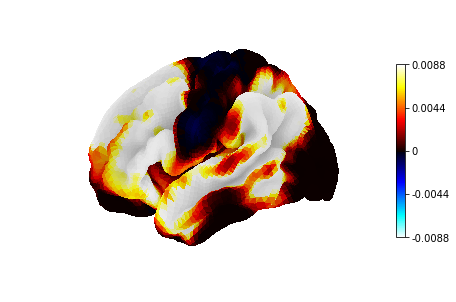

########## bert-base-cased_pre-1_1_post-0_all-hidden-layers_pca_300 ##########


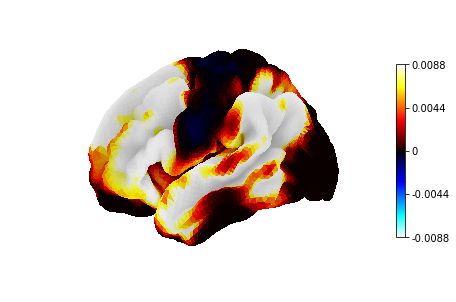

########## bert-base-cased_pre-2_1_post-0_all-hidden-layers_pca_300 ##########


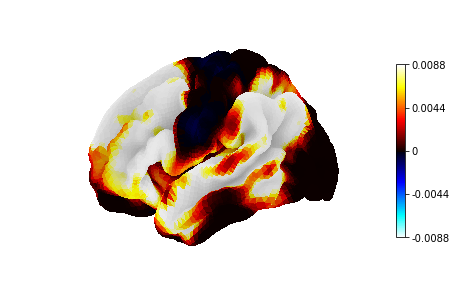

########## bert-base-cased_pre-5_1_post-0_all-hidden-layers_pca_300 ##########


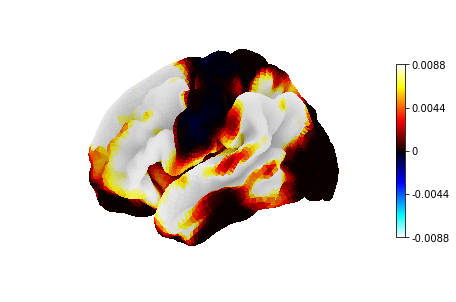

########## bert-base-cased_pre-10_1_post-0_all-hidden-layers_pca_300 ##########


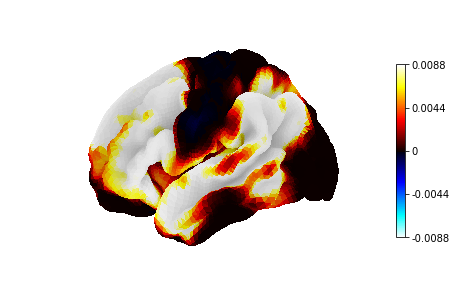

########## bert-base-cased_pre-15_1_post-0_all-hidden-layers_pca_300 ##########


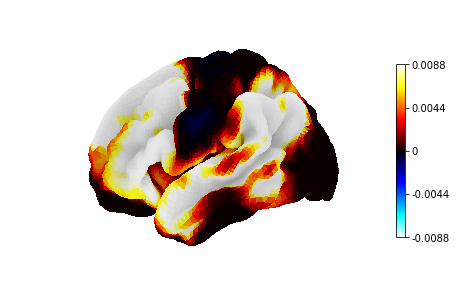

########## bert-base-cased_pre-20_1_post-0_all-hidden-layers_pca_300 ##########


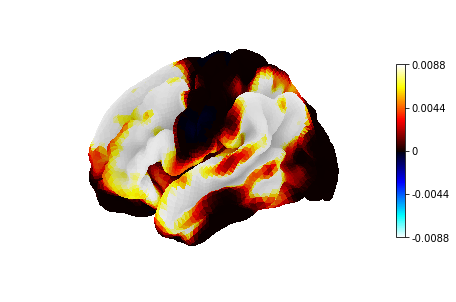

########## bert-base-cased_pre-25_1_post-0_all-hidden-layers_pca_300 ##########


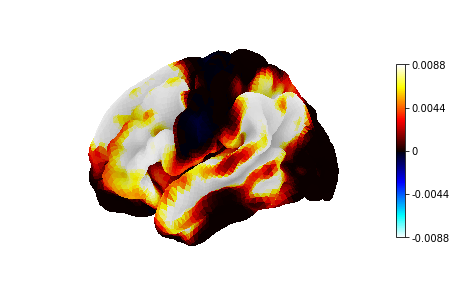

########## bert-base-cased_old_scaled_all-hidden-layers_pca_300 ##########


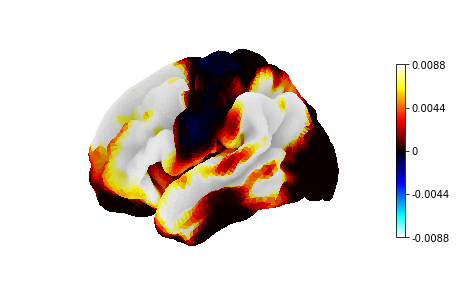

########## glove_300 ##########


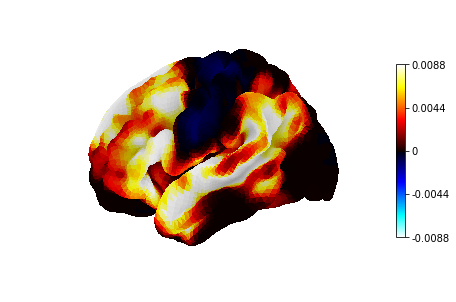

########## LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers ##########


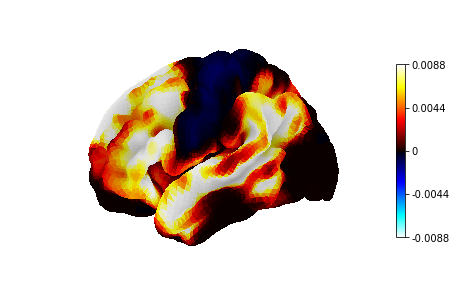

########## gpt2_scaled_all-hidden-layers_pca_300 ##########


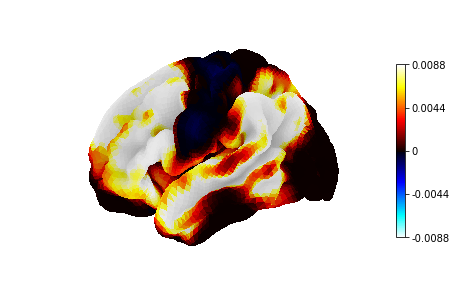

########## bert-base-cased_scaled_all-hidden-layers_pca_300 ##########


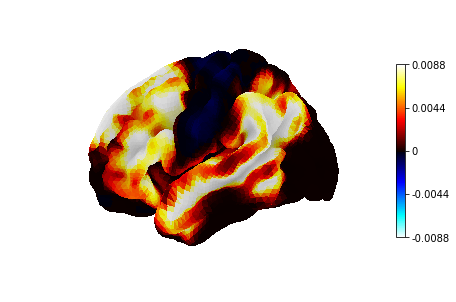

########## bert-base-cased_all-hidden-layers_pca_300 ##########


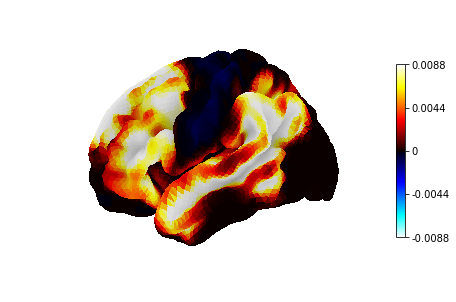

########## bert-base-cased_old_all-hidden-layers_pca_300 ##########


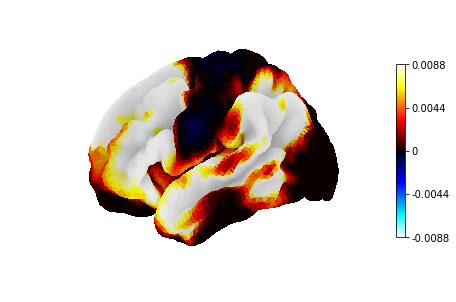

########## BF_rms ##########


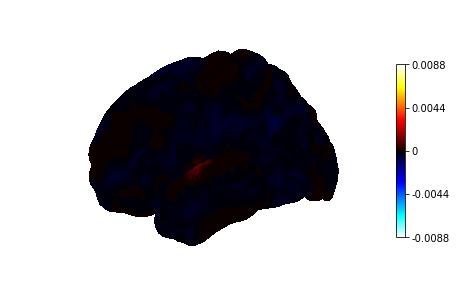

########## BF_log_frequency ##########


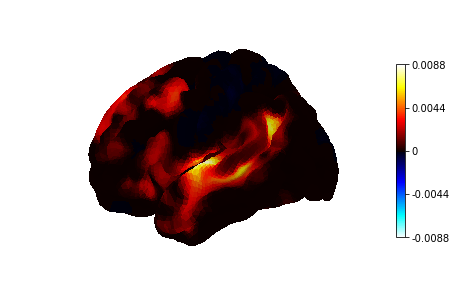

########## BF_wordrate ##########


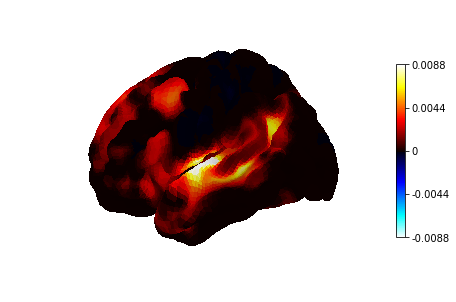

########## BF_content_words ##########


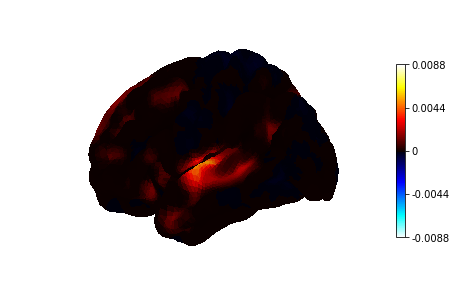

########## BF_function_words ##########


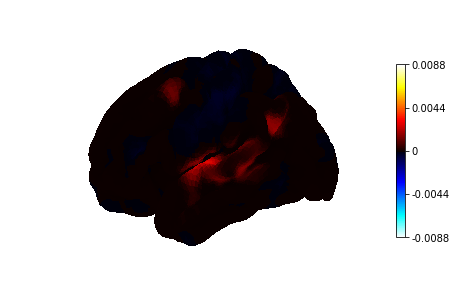

########## BF_word_position ##########


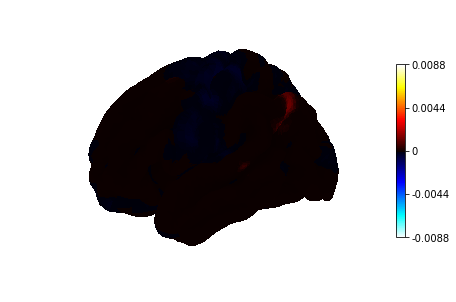

In [48]:
for index_model, model_name in enumerate(model_names):
    name = model_name.replace('_{}', '')
    print("#"*10, name, "#"*10)
    #saving_path = os.path.dirname(paths_group_level[index_model])
    plot_img_surf(paths_group_level[name], saving_path=None, plot_name=model_name+'_surf', inflated=False, vmax=None, **kwargs)
    

## Model Comparison (GloVe - LSTM - GPT2 - BERT)

In [66]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-25_1_post-0_{}_all-hidden-layers_pca_300'
]
legend_names = ['BERT-pre-0_1_post-0-Hpca', 
                'BERT-pre-1_1_post-0-Hpca', 
                'BERT-pre-2_1_post-0-Hpca',  
                'BERT-pre-5_1_post-0-Hpca',
                'BERT-pre-10_1_post-0-Hpca', 
                'BERT-pre-15_1_post-0-Hpca', 
                'BERT-pre-20_1_post-0-Hpca', 
                'BERT-pre-25_1_post-0-Hpca'
               ]

In [67]:
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }

Preparing data for plot per ROI:

In [68]:
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]

		-->Done


In [69]:
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']

### Vertical plots per ROI

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


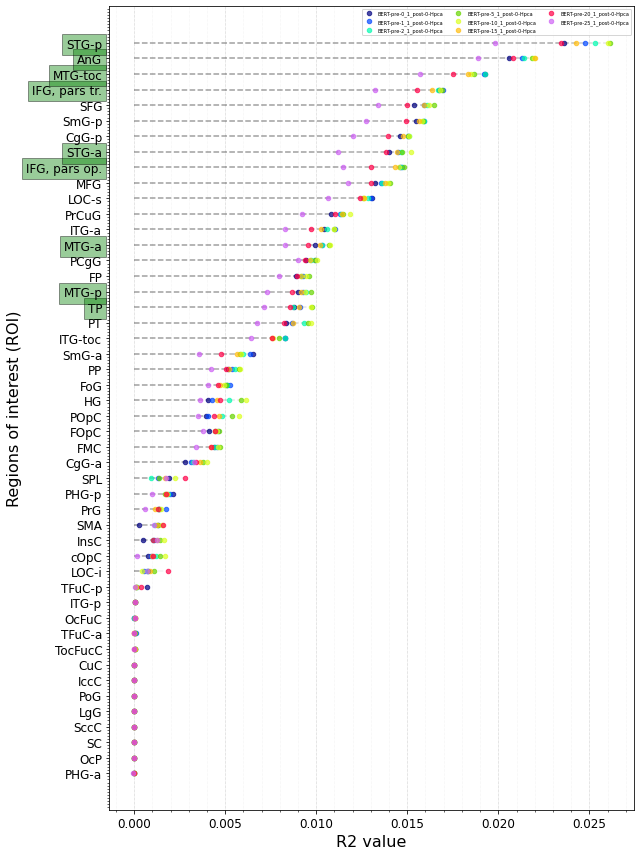

In [70]:
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:19<00:00,  2.47it/s]


		-->Done


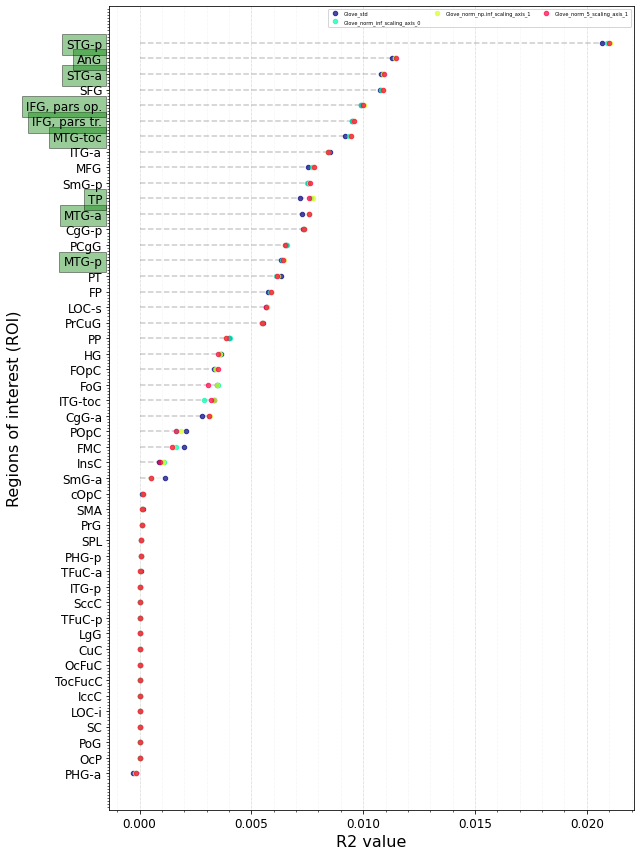

In [27]:
model_names = [
    'glove_300_standardize_centering_{}',
    'glove_300_norm_np.inf_centering_scaling_axis_0_{}',
    'glove_300_norm_np.inf_centering_{}',
    'glove_300_norm_5_centering_scaling_axis_1_{}',
    #'glove_300_norm_4_centering_scaling_axis_1_{}',
    #'glove_300_norm_3_centering_scaling_axis_1_{}',
    #'glove_300_norm_2_centering_{}',
]
legend_names = [
    'Glove_std',
    'Glove_norm_inf_scaling_axis_0',
    'Glove_norm_np.inf_scaling_axis_1',
    'Glove_norm_5_scaling_axis_1',
    #'Glove_norm_4_scaling_axis_1',
    #'Glove_norm_3_scaling_axis_1',
    #'Glove_norm_2_scaling_axis_1',
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


		-->Done


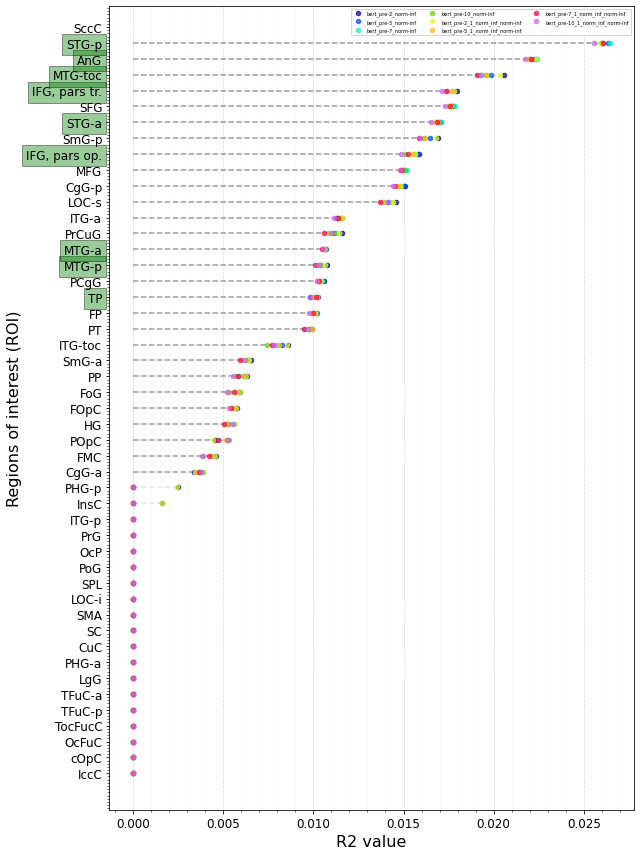

In [16]:
model_names=[
 #'bert-base-cased_pre-0_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-1_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-2_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-5_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-7_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-10_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-15_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-20_1_post-0_norm-None_norm-std_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-0_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-1_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-2_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-5_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 'bert-base-cased_pre-10_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-15_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-20_1_post-0_norm-None_norm-inf_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-0_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-1_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-2_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-5_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-7_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-10_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-15_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-20_1_post-0_norm-None_norm-5_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-0_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-1_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-2_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-5_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-7_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-10_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-15_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-20_1_post-0_norm-None_norm-3_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-0_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-1_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-2_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-5_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-7_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-10_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-15_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
 #'bert-base-cased_pre-20_1_post-0_norm-None_norm-2_{}_hidden-all-layers_pca_300',
   #'bert-base-cased_pre-0_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
]


legend_names = [
 #'bert_pre-0_norm-std',
 #'bert_pre-1_norm-std',
 #'bert_pre-2_norm-std',
 #'bert_pre-5_norm-std',
 #'bert_pre-7_norm-std',
 #'bert_pre-10_norm-std',
 #'bert_pre-15_norm-std',
 #'bert_pre-20_norm-std',
 #'bert_pre-0_norm-inf',
 #'bert_pre-1_norm-inf',
 'bert_pre-2_norm-inf',
 'bert_pre-5_norm-inf',
 'bert_pre-7_norm-inf',
 'bert_pre-10_norm-inf',
 #'bert_pre-15_norm-inf',
 #'bert_pre-20_norm-inf',
 #'bert_pre-0_norm-5',
 #'bert_pre-1_norm-5',
 #'bert_pre-2_norm-5',
 #'bert_pre-5_norm-5',
 #'bert_pre-7_norm-5',
 #'bert_pre-10_norm-5',
 #'bert_pre-15_norm-5',
 #'bert_pre-20_norm-5',
 #'bert_pre-0_norm-3',
 #'bert_pre-1_norm-3',
 #'bert_pre-2_norm-3',
 #'bert_pre-5_norm-3',
 #'bert_pre-7_norm-3',
 #'bert_pre-10_norm-3',
 #'bert_pre-15_norm-3',
 #'bert_pre-20_norm-3',
 #'bert_pre-0_norm-2',
 #'bert_pre-1_norm-2',
 #'bert_pre-2_norm-2',
 #'bert_pre-5_norm-2',
 #'bert_pre-7_norm-2',
 #'bert_pre-10_norm-2',
 #'bert_pre-15_norm-2',
 #'bert_pre-20_norm-2',
    #'bert_pre-0_1_norm_inf_norm-inf',
    #'bert_pre-1_1_norm_inf_norm-inf',
    'bert_pre-2_1_norm_inf_norm-inf',
    'bert_pre-5_1_norm_inf_norm-inf',
    'bert_pre-7_1_norm_inf_norm-inf',
    'bert_pre-10_1_norm_inf_norm-inf',
    #'bert_pre-15_1_norm_inf_norm-inf',
    #'bert_pre-20_1_norm_inf_norm-inf',
]


data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                global_mask=MASKER_PATH,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:37<00:00,  1.27it/s]


		-->Done


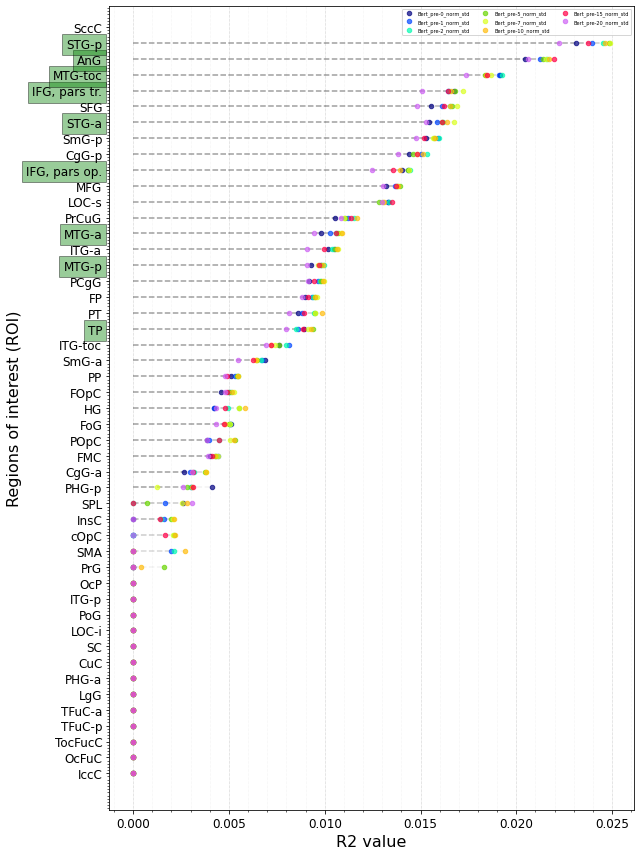

In [29]:
model_names = [
    'bert-base-cased_pre-0_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-1_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-2_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-5_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-7_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-10_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-15_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    'bert-base-cased_pre-20_1_post-0_norm_std_norm-std_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-0_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-2_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-5_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-7_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-10_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_None_norm-None_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-0_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-2_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-5_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-7_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-10_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_inf_norm-np.inf_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-0_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-2_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-5_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-7_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-10_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_5_norm-5_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-0_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-2_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-5_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-7_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-10_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_3_norm-3_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-0_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-1_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-2_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-5_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-7_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-10_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-15_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300',
    #'bert-base-cased_pre-20_1_post-0_norm_2_norm-2_{}_hidden-all-layers_pca_300'
]

legend_names = [
    'Bert_pre-0_norm_std',
    'Bert_pre-1_norm_std',
    'Bert_pre-2_norm_std',
    'Bert_pre-5_norm_std',
    'Bert_pre-7_norm_std',
    'Bert_pre-10_norm_std',
    'Bert_pre-15_norm_std',
    'Bert_pre-20_norm_std',
    #'Bert_pre-0_norm_None',
    #'Bert_pre-1_norm_None',
    #'Bert_pre-2_norm_None',
    #'Bert_pre-5_norm_None',
    #'Bert_pre-7_norm_None',
    #'Bert_pre-10_norm_None',
    #'Bert_pre-15_norm_None',
    #'Bert_pre-20_norm_None',
    #'Bert_pre-0_norm_inf',
    #'Bert_pre-1_norm_inf',
    #'Bert_pre-2_norm_inf',
    #'Bert_pre-5_norm_inf',
    #'Bert_pre-7_norm_inf',
    #'Bert_pre-10_norm_inf',
    #'Bert_pre-15_norm_inf',
    #'Bert_pre-20_norm_inf',
    #'Bert_pre-0_norm_5_',
    #'Bert_pre-1_norm_5',
    #'Bert_pre-2_norm_5',
    #'Bert_pre-5_norm_5',
    #'Bert_pre-7_norm_5',
    #'Bert_pre-10_norm_5',
    #'Bert_pre-15_norm_5',
    #'Bert_pre-20_norm_5',
    #'Bert_pre-0_norm_3',
    #'Bert_pre-1_norm_3',
    #'Bert_pre-2_norm_3',
    #'Bert_pre-5_norm_3',
    #'Bert_pre-7_norm_3',
    #'Bert_pre-10_norm_3',
    #'Bert_pre-15_norm_3',
    #'Bert_pre-20_norm_3',
    #'Bert_pre-0_norm_2',
    #'Bert_pre-1_norm_2',
    #'Bert_pre-2_norm_2',
    #'Bert_pre-5_norm_2',
    #'Bert_pre-7_norm_2',
    #'Bert_pre-10_norm_2',
    #'Bert_pre-15_norm_2',
    #'Bert_pre-20_norm_2'
]


data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                global_mask=MASKER_PATH,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


		-->Done


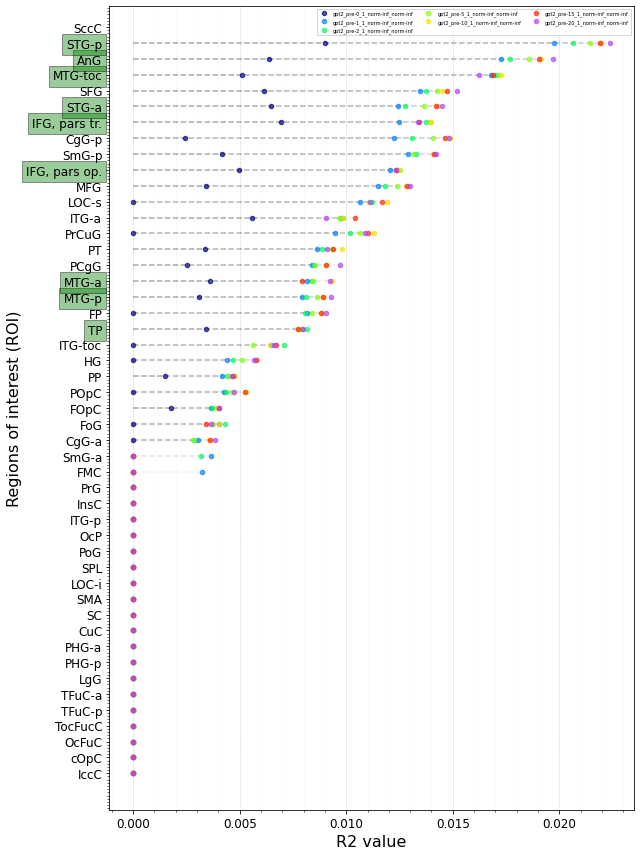

In [24]:
model_names = [
 #'gpt2_pre-0_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-1_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-2_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-5_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-10_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-15_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-20_1_norm-std_norm-std_{}_hidden-all-layers_pca_300',
 'gpt2_pre-0_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-1_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-2_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-5_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-10_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-15_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 'gpt2_pre-20_1_norm-inf_norm-inf_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-0_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-1_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-2_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-5_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-10_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-15_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-20_1_norm-5_norm-5_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-0_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-1_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-2_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-5_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-10_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-15_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-20_1_norm-3_norm-3_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-0_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-1_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-2_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-5_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-10_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-15_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
 #'gpt2_pre-20_1_norm-2_norm-2_{}_hidden-all-layers_pca_300',
]


legend_names = [
 #'gpt2_pre-0_1_norm-std_norm-std',
 #'gpt2_pre-1_1_norm-std_norm-std',
 #'gpt2_pre-2_1_norm-std_norm-std',
 #'gpt2_pre-5_1_norm-std_norm-std',
 #'gpt2_pre-10_1_norm-std_norm-std',
 #'gpt2_pre-15_1_norm-std_norm-std',
 #'gpt2_pre-20_1_norm-std_norm-std',
 'gpt2_pre-0_1_norm-inf_norm-inf',
 'gpt2_pre-1_1_norm-inf_norm-inf',
 'gpt2_pre-2_1_norm-inf_norm-inf',
 'gpt2_pre-5_1_norm-inf_norm-inf',
 'gpt2_pre-10_1_norm-inf_norm-inf',
 'gpt2_pre-15_1_norm-inf_norm-inf',
 'gpt2_pre-20_1_norm-inf_norm-inf',
 #'gpt2_pre-0_1_norm-5_norm-5',
 #'gpt2_pre-1_1_norm-5_norm-5',
 #'gpt2_pre-2_1_norm-5_norm-5',
 #'gpt2_pre-5_1_norm-5_norm-5',
 #'gpt2_pre-10_1_norm-5_norm-5',
 #'gpt2_pre-15_1_norm-5_norm-5',
 #'gpt2_pre-20_1_norm-5_norm-5',
 #'gpt2_pre-0_1_norm-3_norm-3',
 #'gpt2_pre-1_1_norm-3_norm-3',
 #'gpt2_pre-2_1_norm-3_norm-3',
 #'gpt2_pre-5_1_norm-3_norm-3',
 #'gpt2_pre-10_1_norm-3_norm-3',
 #'gpt2_pre-15_1_norm-3_norm-3',
 #'gpt2_pre-20_1_norm-3_norm-3',
 #'gpt2_pre-0_1_norm-2_norm-2',
 #'gpt2_pre-1_1_norm-2_norm-2',
 #'gpt2_pre-2_1_norm-2_norm-2',
 #'gpt2_pre-5_1_norm-2_norm-2',
 #'gpt2_pre-10_1_norm-2_norm-2',
 #'gpt2_pre-15_1_norm-2_norm-2',
 #'gpt2_pre-20_1_norm-2_norm-2',
]


data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                global_mask=MASKER_PATH,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

In [25]:
labels

['Background',
 'Frontal Pole',
 'Insular Cortex',
 'Superior Frontal Gyrus',
 'Middle Frontal Gyrus',
 'Inferior Frontal Gyrus, pars triangularis',
 'Inferior Frontal Gyrus, pars opercularis',
 'Precentral Gyrus',
 'Temporal Pole',
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, anterior division',
 'Middle Temporal Gyrus, posterior division',
 'Middle Temporal Gyrus, temporooccipital part',
 'Inferior Temporal Gyrus, anterior division',
 'Inferior Temporal Gyrus, posterior division',
 'Inferior Temporal Gyrus, temporooccipital part',
 'Postcentral Gyrus',
 'Superior Parietal Lobule',
 'Supramarginal Gyrus, anterior division',
 'Supramarginal Gyrus, posterior division',
 'Angular Gyrus',
 'Lateral Occipital Cortex, superior division',
 'Lateral Occipital Cortex, inferior division',
 'Intracalcarine Cortex',
 'Frontal Medial Cortex',
 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
 'Subcallo

In [14]:
tmp = reporting.prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='R2', 
    language='english', 
    includ_context=True,
    includ_norm=True,
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

	Looping through labeled masks...


  4%|▍         | 2/48 [24:20<9:19:57, 730.38s/it]


KeyboardInterrupt: 

In [14]:
def prepare_data_for_anova(
    model_names, 
    atlas_maps, 
    labels, 
    global_mask,
    object_of_interest='R2', 
    language='english', 
    includ_context=False,
    includ_norm=False,
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    ):
    print("\tLooping through labeled masks...")
    result = []
    data = {}
    for model_name in model_names:
        name = model_name.replace('_{}', '')
        data[name] = {}
        for subject_id in possible_subjects_id(language):
            subject = get_subject_name(subject_id)
            path_to_map = os.path.join(OUTPUT_PATH, subject, model_name.format(subject_id))
            data[name][subject] = {
                object_of_interest: reporting.fetch_map(path_to_map, object_of_interest)[0]
            }

    for index_mask in tqdm(range(1, len(labels)-1)):
        print(labels[index_mask+1])
        mask = math_img('img > 20', img=index_img(atlas_maps, index_mask))
        global_masker = nib.load(global_mask + '.nii.gz')
        mask_resampled = math_img('img > 0.5', img=nilearn.image.resample_to_img(mask, global_masker)) #, interpolation='nearest'
        #mask_resampled = nilearn.image.resample_to_img(mask, global_masker, interpolation='nearest')
        print(np.sum(mask_resampled.get_data()))
        print(np.sum(mask.get_data()))
        params = read_yaml(global_mask + '.yml')
        params['detrend'] = False
        params['standardize'] = False
        masker = MultiNiftiMasker()
        masker.set_params(**params)
        masker.fit([mask])
        masker_resampled = MultiNiftiMasker(mask_resampled)
        masker_resampled.set_params(**params)
        masker_resampled.fit() #[mask_resampled]
        for name in data.keys():
            for subject in data[name].keys():
                print('-'*10)
                try:
                    array = masker.transform(data[name][subject][object_of_interest])
                    print(array.shape, np.sum(np.isnan(array)))
                    array_resampled = masker_resampled.transform(data[name][subject][object_of_interest])
                    print(array_resampled.shape, np.sum(np.isnan(array_resampled)))
                    mean = np.mean(array)
                    median = np.median(array)
                    third_quartile = np.percentile(array, 75)
                except ValueError:
                    print(np.nan, np.nan)
                    mean = np.nan
                    median = np.nan
                    third_quartile = np.nan
                result.append([name, subject, labels[index_mask + 1], mean, median, third_quartile])
    result = pd.DataFrame(result, columns=['model', 'subject', 'ROI', 'R2_mean', 'R2_median', 'R2_3rd_quartile'])
    if includ_context or includ_norm:
        final_result = []
        for index, row in result.iterrows():
            context_pre = row['model'].split('pre-')[1].split('_')[0] if includ_context else None
            context_post = row['model'].split('_norm_')[0].split('-')[-1] if includ_context else None
            norm = row['model'].split('_norm_')[1].split('_')[0] if includ_norm else None
            name = row['model'].split('_pre-')[0] + '_'.join(row['model'].split('_')[-3:])
            final_result.append([name, context_pre, context_post, norm, row['subject'], row['ROI'], row['R2_mean'], row['R2_median'], row['R2_3rd_quartile']])
        result = pd.DataFrame(final_result, columns=['model', 'context_pre', 'context_post', 'norm', 'subject', 'ROI', 'R2_mean', 'R2_median', 'R2_3rd_quartile'])
    print("\t\t-->Done")
    return result

In [43]:
tmp = pd.read_csv('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/anova_bert_aligned.csv')

In [19]:
#tmp.to_csv('/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/anova_bert_aligned.csv', index=False)

In [54]:
tmp

model  context_pre  context_post  \
0       bert-base-casedhidden-all-layers_pca_300            0             0   
1       bert-base-casedhidden-all-layers_pca_300            0             0   
2       bert-base-casedhidden-all-layers_pca_300            0             0   
3       bert-base-casedhidden-all-layers_pca_300            0             0   
4       bert-base-casedhidden-all-layers_pca_300            0             0   
...                                          ...          ...           ...   
117499  bert-base-casedhidden-all-layers_pca_300           20             0   
117500  bert-base-casedhidden-all-layers_pca_300           20             0   
117501  bert-base-casedhidden-all-layers_pca_300           20             0   
117502  bert-base-casedhidden-all-layers_pca_300           20             0   
117503  bert-base-casedhidden-all-layers_pca_300           20             0   

       norm  subject             ROI   R2_mean  R2_median  R2_3rd_quartile  
0       std  sub-057    Frontal Pole  0.027955   0.019281         0.042740  
1       std  sub-058    Frontal Pole  0.006747   0.000000         0.008149  
2       std  sub-059    Frontal Pole  0.003730   0.000000         0.005743  
3       std  sub-061    Frontal Pole  0.003043  -0.000134         0.005133  
4       std  sub-062    Frontal Pole  0.017147   0.009778         0.028216  
...     ...      ...             ...       ...        ...              ...  
117499    2  sub-109  Occipital Pole  0.001421   0.000000         0.000000  
117500    2  sub-110  Occipital Pole -0.062054   0.000000         0.000000  
117501    2  sub-113  Occipital Pole -0.000870   0.000000         0.000000  
117502    2  sub-114  Occipital Pole  0.002562   0.000000         0.001457  
117503    2  sub-115  Occipital Pole -0.000055   0.000000         0.000000  

[117504 rows x 9 columns]

In [69]:
from statsmodels.stats.anova import AnovaRM

#for norm_ in np.unique(tmp.norm.values):
#    for context_post in np.unique(tmp.context_post.values):
        #print(tmp.keys())
        #reporting.anova(
        #    tmp[tmp.norm==norm_], 
        #    anova_type='rm_anova', 
        #    dv='R2_median', 
        #    within=['context_pre', 'ROI'], 
        #    subject='subject')
table = AnovaRM(tmp, depvar='R2_median', subject='subject', within=['context_pre', 'ROI', 'norm'] )
res = table.fit()

print(res)

MemoryError: Unable to allocate 30.9 GiB for an array with shape (35254, 117504) and data type float64

def anova(data, anova_type, dv, within=None, between=None, subject=None, detailed=True, correction=False, effsize='np2', method='pearson', padjust='fdr_bh', columns=None):
    """Compute various ANOVA type analysis on data. Available functions are:
    anova, rm_anova, pairwise_ttests, mixed_anova, pairwise_corr.
    """
    if anova_type=='anova':
        result = pg.anova(data=data, dv=dv, between=between, detailed=detailed)
    elif anova_type=='rm_anova':
        result = pg.rm_anova(data=data, dv=dv, within=within, subject=subject, detailed=detailed)
    elif anova_type=='pairwise_ttests':
        result = pg.pairwise_ttests(data=data, dv=dv, within=within, subject=subject,
                             parametric=True, padjust=padjust, effsize='hedges')
    elif anova_type=='mixed_anova':
        result = pg.mixed_anova(data=data, dv=dv, between=between, within=within,
                     subject=subject, correction=False, effsize=effsize)
    elif anova_type=='pairwise_corr':
        result = pg.pairwise_corr(data, columns=columns, method=method)
    pg.print_table(result, floatfmt='.3f')
    return result

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


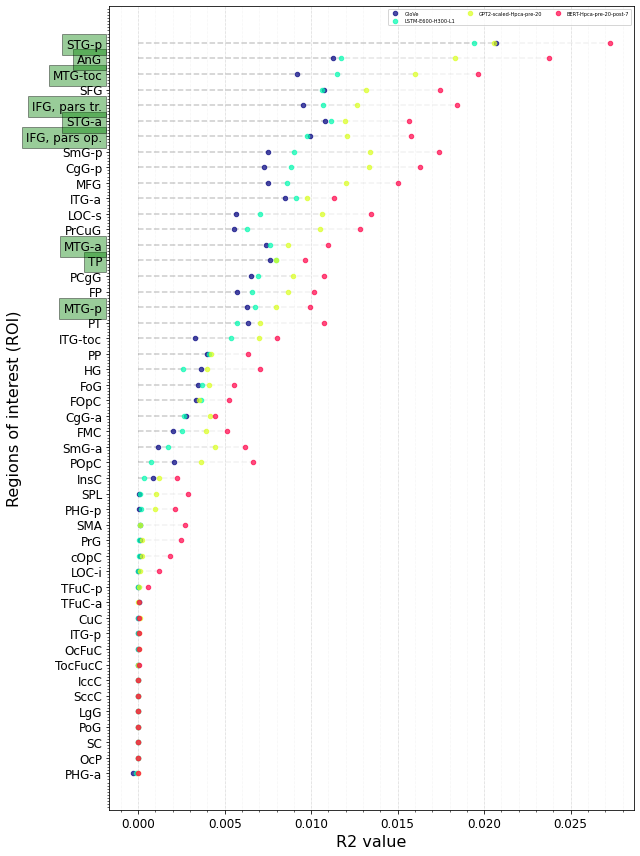

In [34]:
model_names = [
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300'
]
legend_names = ['GloVe', 
                'LSTM-E600-H300-L1', 
                'GPT2-scaled-Hpca-pre-20', 
                'BERT-Hpca-pre-20-post-7'
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

In [55]:
def horizontal_plot(
    data, 
    legend_names, 
    analysis_name, 
    save_folder, 
    label_names,
    figsize=(9,20), 
    title=None, 
    ylabel='Regions of interest (ROI)', 
    xlabel='R2 value', 
    model_name=''
    ):
    """Plots models horizontally.
    """

    limit = None
    dash_inf = limit[0] if limit is not None else 0
    plt.figure(figsize=figsize) # (7.6,12)
    ax = plt.axes()
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, data.shape[0] + 1)]
    for col in range(data.shape[0]):
        plt.plot(legend_names, data[col, :], '.-', alpha=0.7, markersize=9, color=colors[col])
    plt.title(title)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)

    plt.xlim(limit)
    plt.minorticks_on()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='y')
    plt.grid(which='major', linestyle=':', linewidth='0.5', color='black', alpha=0.4, axis='x')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.1, axis='x')
    plt.legend(label_names, ncol=3, bbox_to_anchor=(0,0,1,1), fontsize=10)

    plt.tight_layout()
    check_folder(save_folder)
    if save_folder:
        plt.savefig(os.path.join(save_folder, '{model_name}-{analysis_name}.png'.format(model_name=model_name,
                                                                                        analysis_name=analysis_name)))
        plt.close('all')
    else:
        plt.show()

In [41]:
model_names = [
    'glove_300_{}',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300'
]
legend_names = ['GloVe', 
                'LSTM-E600-H300-L1', 
                'GPT2-scaled-Hpca-pre-20', 
                'BERT-Hpca-pre-20-post-7'
               ]

data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:16<00:00,  2.91it/s]

		-->Done


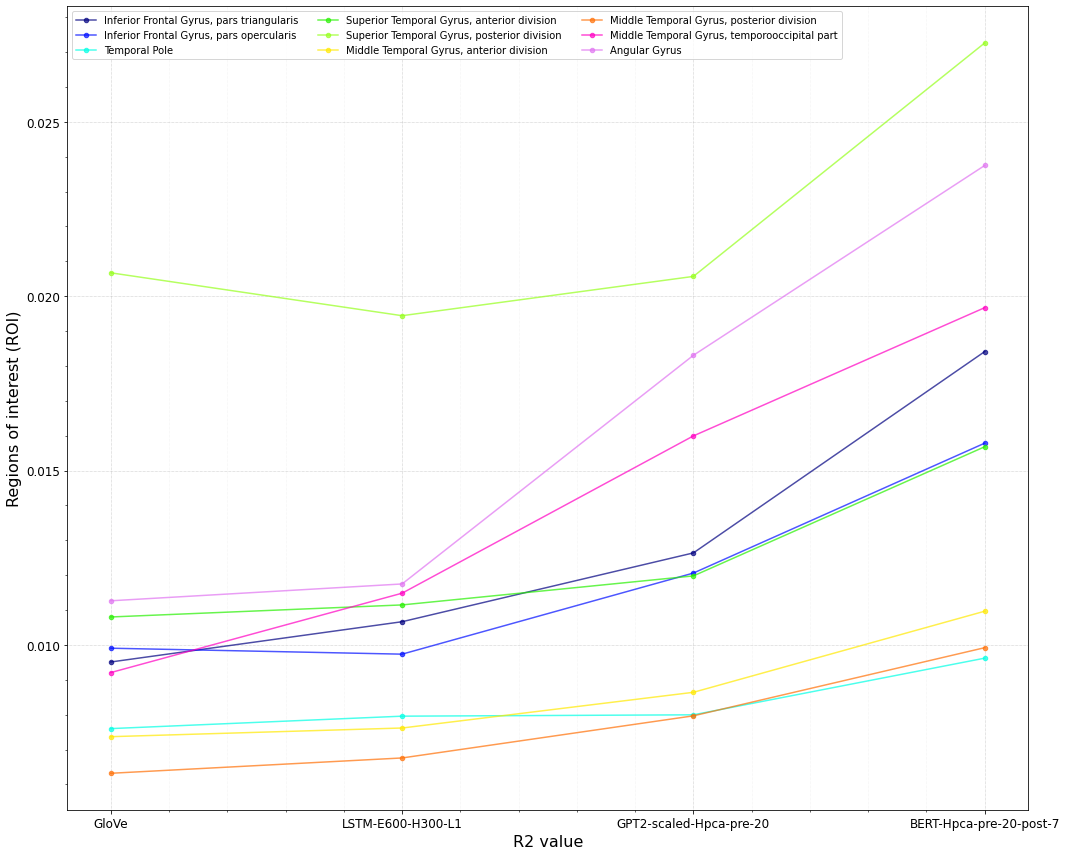

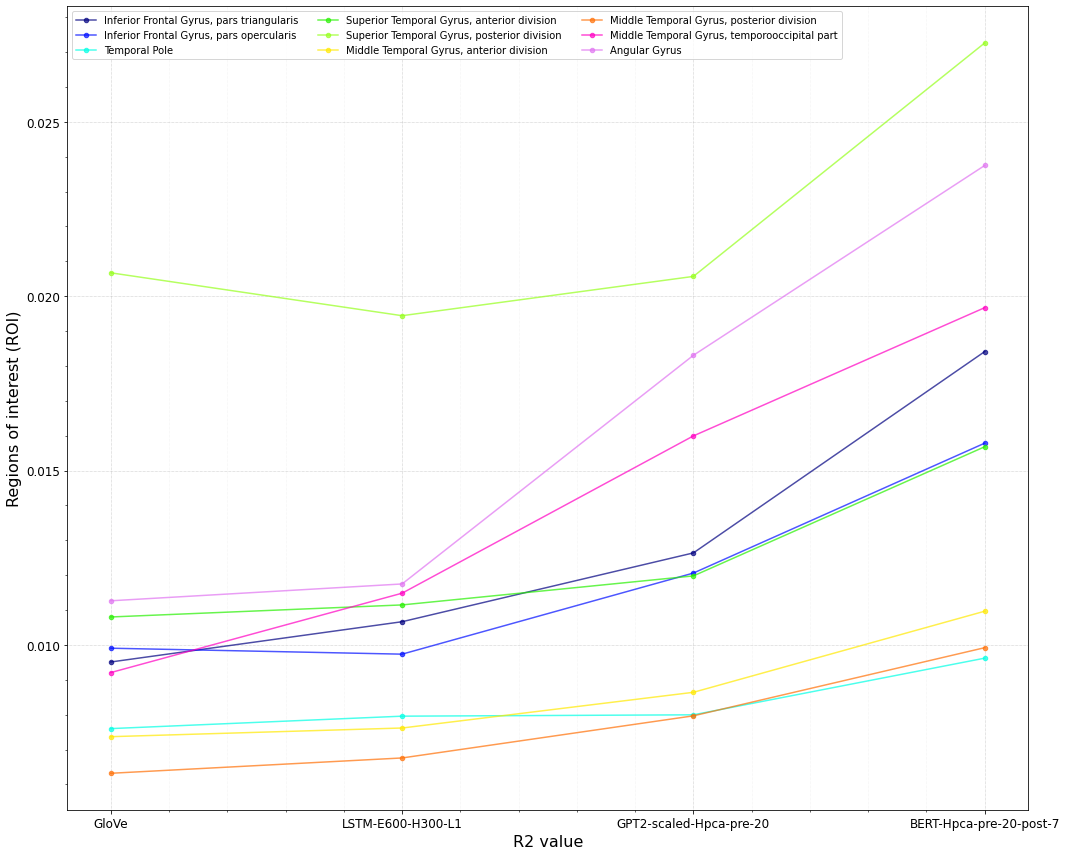

In [56]:
def clever_plot(data, x_labels, model_names):
    syntactic_data = []
    language_data = []
    legends = []
    for name in load_syntactic_roi():
        if name in x_labels:
            syntactic_data.append(data[x_labels.index(name), :])
            legends.append(name)
    syntactic_data = np.vstack(syntactic_data)
    horizontal_plot(
        syntactic_data, 
        model_names, 
        analysis_name='Third_Quartile_R2_per_syntactic_ROI', 
        save_folder=None, 
        label_names=legends,
        figsize=(15,12), 
        title=None, 
        ylabel='Regions of interest (ROI)', 
        xlabel='R2 value', 
        model_name='Model_comparison'
        )
    legends = []
    for name in load_language_roi():
        if name in x_labels:
            language_data.append(data[x_labels.index(name), :])
            legends.append(name)
    language_data = np.vstack(language_data)
    horizontal_plot(
        language_data, 
        model_names, 
        analysis_name='Third_Quartile_R2_per_language_ROI', 
        save_folder=None, 
        label_names=legends,
        figsize=(15,12), 
        title=None, 
        ylabel='Regions of interest (ROI)', 
        xlabel='R2 value', 
        model_name='Model_comparison'
        )
    
clever_plot(third_quartile, x_labels, legend_names)

#horizontal_plot(
#    third_quartile, 
#    legend_names, 
#    analysis_name='Third_Quartile_R2_per_ROI', 
#    save_folder=None, 
#    label_names=x_labels,
#    figsize=(15,12), 
#    title=None, 
#    ylabel='Regions of interest (ROI)', 
#    xlabel='R2 value', 
#    model_name='Model_comparison'
#    )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


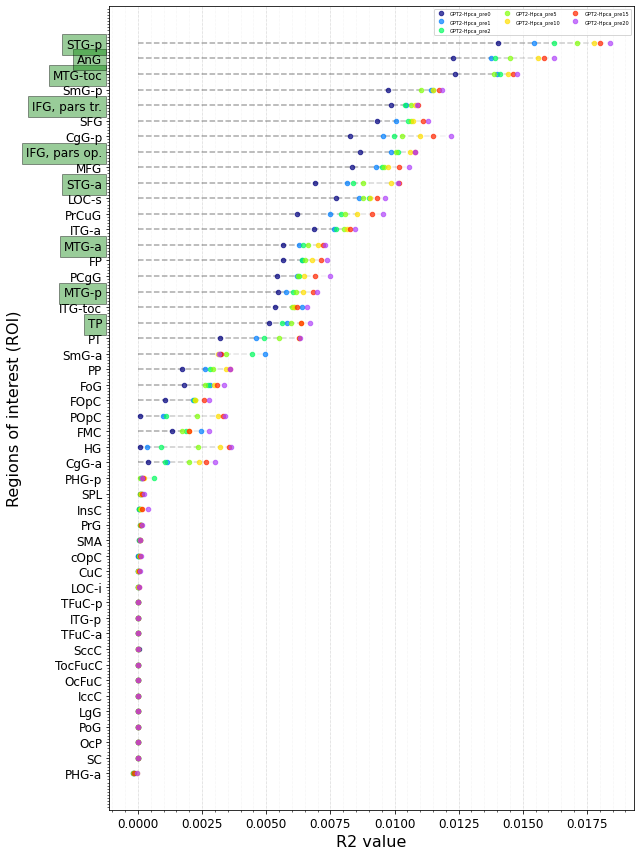

In [25]:
model_names = ['gpt2_pre-0_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-2_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['GPT2-Hpca_pre0',
                'GPT2-Hpca_pre1', 
                'GPT2-Hpca_pre2', 
                'GPT2-Hpca_pre5', 
                'GPT2-Hpca_pre10', 
                'GPT2-Hpca_pre15',
                'GPT2-Hpca_pre20'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:22<00:00,  2.11it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


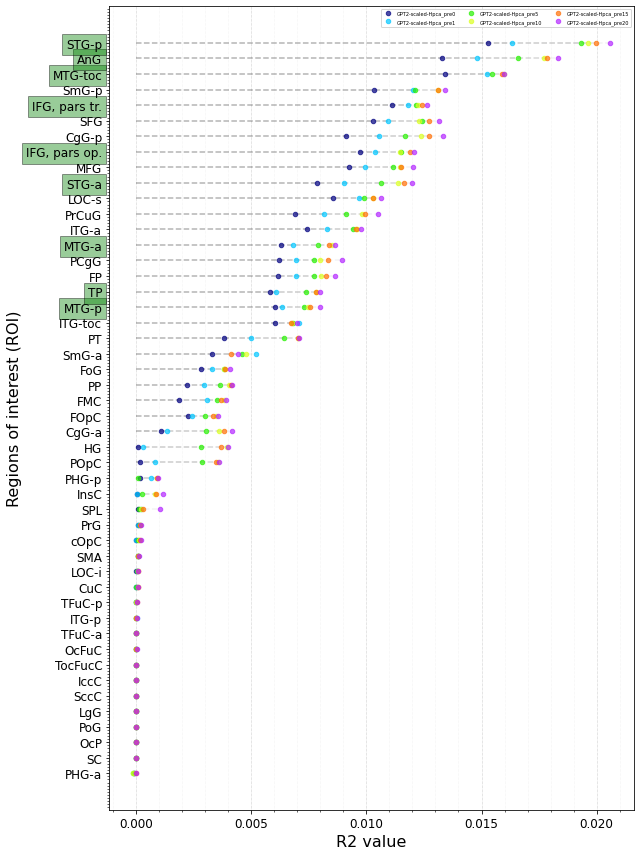

In [26]:
model_names = [
    'gpt2_pre-0_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-1_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-5_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-10_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-15_1_scaled_{}_all-hidden-layers_pca_300',
    'gpt2_pre-20_1_scaled_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['GPT2-scaled-Hpca_pre0',
                'GPT2-scaled-Hpca_pre1', 
                'GPT2-scaled-Hpca_pre5', 
                'GPT2-scaled-Hpca_pre10', 
                'GPT2-scaled-Hpca_pre15',
                'GPT2-scaled-Hpca_pre20'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:26<00:00,  1.81it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


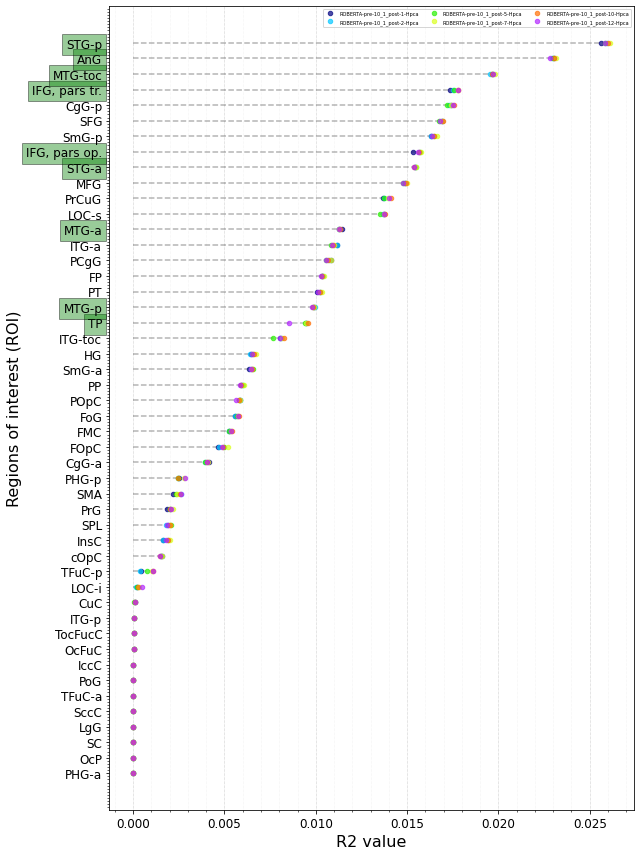

In [15]:
model_names = [
    'roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
              ]
legend_names = ['ROBERTA-pre-10_1_post-1-Hpca',
                'ROBERTA-pre-10_1_post-2-Hpca',
                'ROBERTA-pre-10_1_post-5-Hpca',
                'ROBERTA-pre-10_1_post-7-Hpca',
                'ROBERTA-pre-10_1_post-10-Hpca',
                'ROBERTA-pre-10_1_post-12-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:20<00:00,  2.31it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


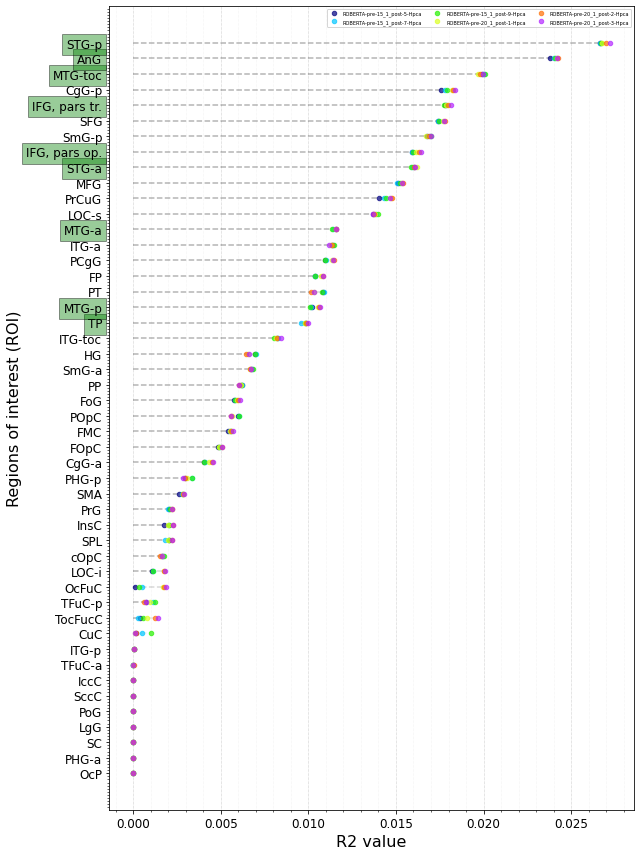

In [16]:
model_names = [
    'roberta-base_pre-15_1_post-5_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-7_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-9_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-1_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-2_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-3_{}_all-hidden-layers_pca_300'
              ]
legend_names = ['ROBERTA-pre-15_1_post-5-Hpca',
                'ROBERTA-pre-15_1_post-7-Hpca',
                'ROBERTA-pre-15_1_post-9-Hpca',
                'ROBERTA-pre-20_1_post-1-Hpca',
                'ROBERTA-pre-20_1_post-2-Hpca',
                'ROBERTA-pre-20_1_post-3-Hpca'
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:25<00:00,  1.85it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


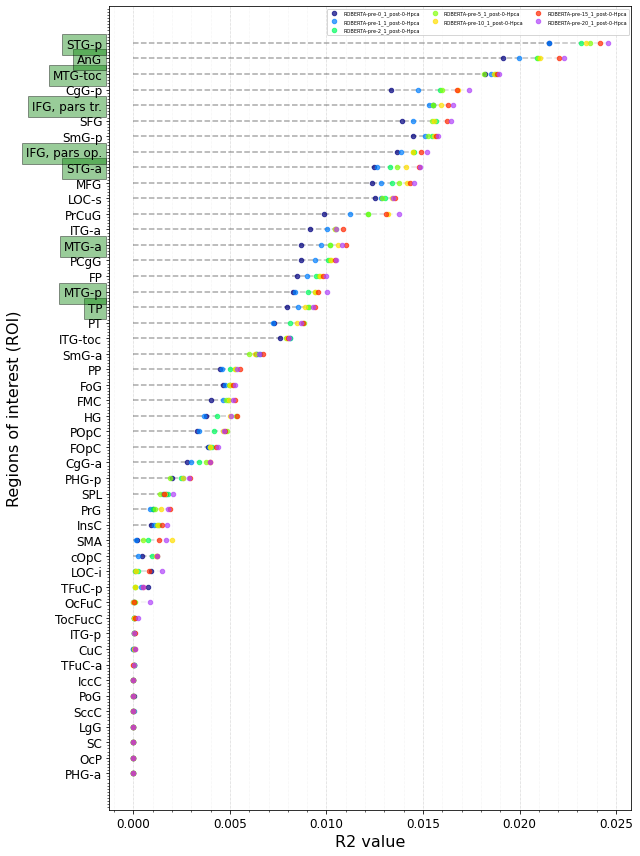

In [17]:
model_names = [
    'roberta-base_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-2_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'roberta-base_pre-20_1_post-0_{}_all-hidden-layers_pca_300'    
              ]
legend_names = ['ROBERTA-pre-0_1_post-0-Hpca',
                'ROBERTA-pre-1_1_post-0-Hpca',
                'ROBERTA-pre-2_1_post-0-Hpca',
                'ROBERTA-pre-5_1_post-0-Hpca',
                'ROBERTA-pre-10_1_post-0-Hpca',
                'ROBERTA-pre-15_1_post-0-Hpca',
                'ROBERTA-pre-20_1_post-0-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:27<00:00,  1.73it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


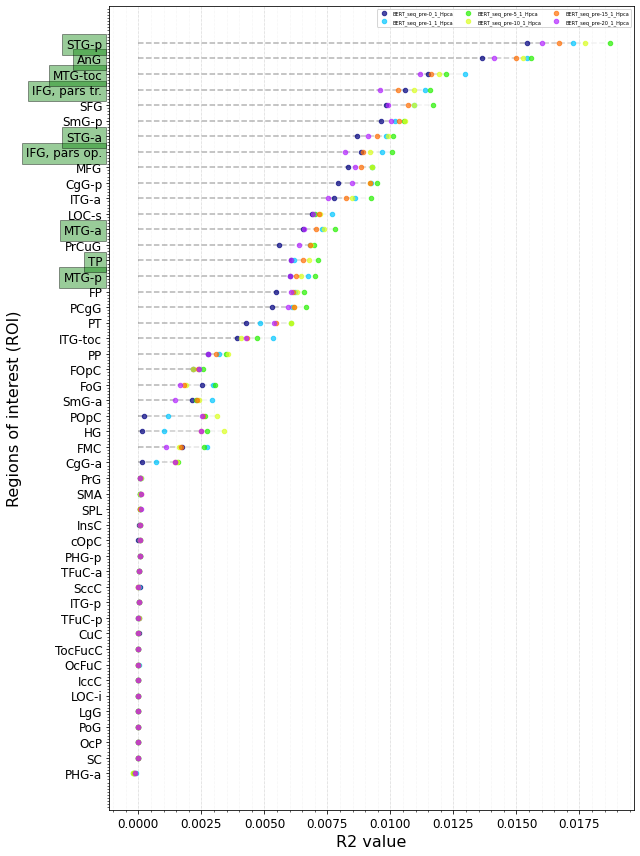

In [63]:
model_names = [
    'bert-base-cased_seq_pre-0_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-1_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-5_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-15_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_seq_pre-20_1_post-0_{}_all-hidden-layers_pca_300'    
              ]
legend_names = ['BERT_seq_pre-0_1_Hpca',
                'BERT_seq_pre-1_1_Hpca',
                'BERT_seq_pre-5_1_Hpca',
                'BERT_seq_pre-10_1_Hpca',
                'BERT_seq_pre-15_1_Hpca',
                'BERT_seq_pre-20_1_Hpca',
                ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


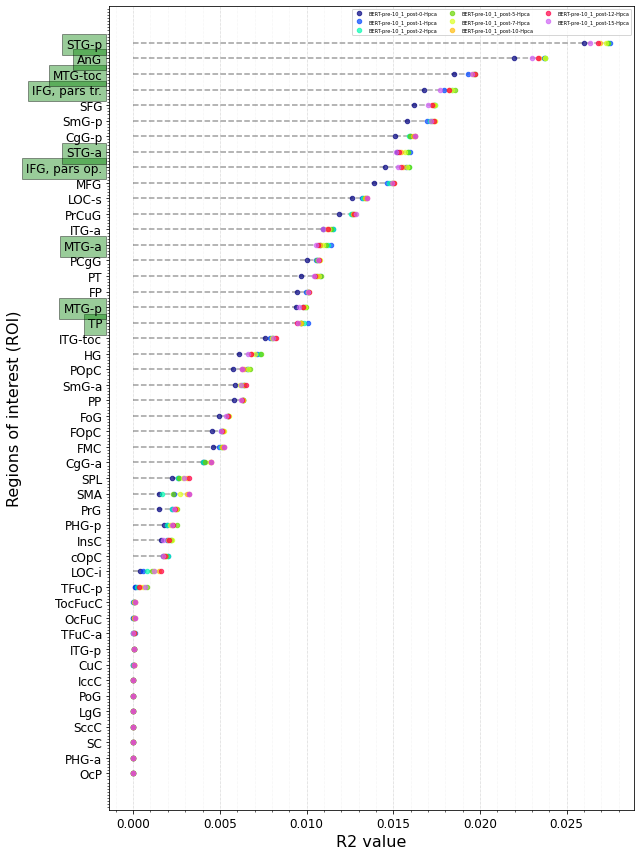

In [64]:
model_names = [
    'bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
              ]
legend_names = ['BERT-pre-10_1_post-0-Hpca',
                'BERT-pre-10_1_post-1-Hpca',
                'BERT-pre-10_1_post-2-Hpca',
                'BERT-pre-10_1_post-5-Hpca',
                'BERT-pre-10_1_post-7-Hpca',
                'BERT-pre-10_1_post-10-Hpca',
                'BERT-pre-10_1_post-12-Hpca',
                'BERT-pre-10_1_post-15-Hpca',
                
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:38<00:00,  1.24it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """)


		-->Done


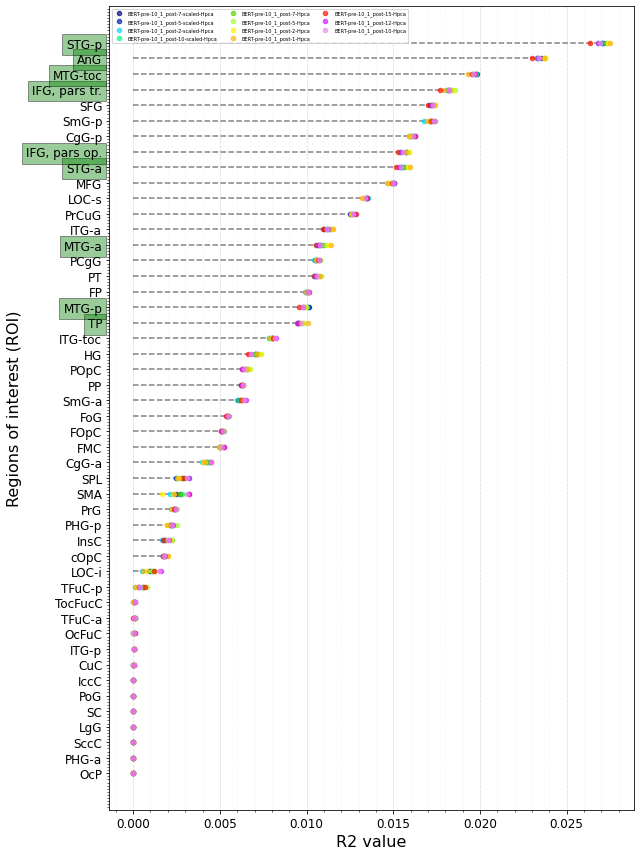

In [31]:
model_names = [
    'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300', #'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-15_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300',
    'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300',
              ]

legend_names = [
                'BERT-pre-10_1_post-7-scaled-Hpca',
                'BERT-pre-10_1_post-5-scaled-Hpca',
                'BERT-pre-10_1_post-2-scaled-Hpca',
                'BERT-pre-10_1_post-10-scaled-Hpca', #'BERT-pre-10_1_post-0-scaled-Hpca',
                'BERT-pre-10_1_post-7-Hpca',
                'BERT-pre-10_1_post-5-Hpca',
                'BERT-pre-10_1_post-2-Hpca',
                'BERT-pre-10_1_post-1-Hpca',
                'BERT-pre-10_1_post-15-Hpca',
                'BERT-pre-10_1_post-12-Hpca',
                'BERT-pre-10_1_post-10-Hpca',
               ]
data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }
data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

In [25]:
df = pd.DataFrame(third_quartile.T, columns=x_labels)
df.index = pd.Index(legend_names)
df

Frontal Pole  Insular Cortex  \
BERT-pre-10_1_post-7-scaled-Hpca       0.010043        0.001862   
BERT-pre-10_1_post-5-scaled-Hpca       0.009974        0.001799   
BERT-pre-10_1_post-2-scaled-Hpca       0.009884        0.001677   
BERT-pre-10_1_post-10-scaled-Hpca      0.010013        0.001884   
BERT-pre-10_1_post-7-Hpca              0.010136        0.002028   
BERT-pre-10_1_post-5-Hpca              0.010099        0.002212   
BERT-pre-10_1_post-2-Hpca              0.010043        0.002088   
BERT-pre-10_1_post-1-Hpca              0.010047        0.001920   
BERT-pre-10_1_post-15-Hpca             0.010058        0.001768   
BERT-pre-10_1_post-12-Hpca             0.010107        0.002249   
BERT-pre-10_1_post-10-Hpca             0.010038        0.001933   

                                   Superior Frontal Gyrus  \
BERT-pre-10_1_post-7-scaled-Hpca                 0.017240   
BERT-pre-10_1_post-5-scaled-Hpca                 0.017142   
BERT-pre-10_1_post-2-scaled-Hpca                 0.017183   
BERT-pre-10_1_post-10-scaled-Hpca                0.017258   
BERT-pre-10_1_post-7-Hpca                        0.017386   
BERT-pre-10_1_post-5-Hpca                        0.017380   
BERT-pre-10_1_post-2-Hpca                        0.017433   
BERT-pre-10_1_post-1-Hpca                        0.017436   
BERT-pre-10_1_post-15-Hpca                       0.016916   
BERT-pre-10_1_post-12-Hpca                       0.017276   
BERT-pre-10_1_post-10-Hpca                       0.017245   

                                   Middle Frontal Gyrus  \
BERT-pre-10_1_post-7-scaled-Hpca               0.015060   
BERT-pre-10_1_post-5-scaled-Hpca               0.014917   
BERT-pre-10_1_post-2-scaled-Hpca               0.014725   
BERT-pre-10_1_post-10-scaled-Hpca              0.015058   
BERT-pre-10_1_post-7-Hpca                      0.014995   
BERT-pre-10_1_post-5-Hpca                      0.014914   
BERT-pre-10_1_post-2-Hpca                      0.014760   
BERT-pre-10_1_post-1-Hpca                      0.014632   
BERT-pre-10_1_post-15-Hpca                     0.014803   
BERT-pre-10_1_post-12-Hpca                     0.015040   
BERT-pre-10_1_post-10-Hpca                     0.014964   

                                   Inferior Frontal Gyrus, pars triangularis  \
BERT-pre-10_1_post-7-scaled-Hpca                                    0.018133   
BERT-pre-10_1_post-5-scaled-Hpca                                    0.018264   
BERT-pre-10_1_post-2-scaled-Hpca                                    0.018160   
BERT-pre-10_1_post-10-scaled-Hpca                                   0.018078   
BERT-pre-10_1_post-7-Hpca                                           0.018354   
BERT-pre-10_1_post-5-Hpca                                           0.018523   
BERT-pre-10_1_post-2-Hpca                                           0.018398   
BERT-pre-10_1_post-1-Hpca                                           0.017986   
BERT-pre-10_1_post-15-Hpca                                          0.017806   
BERT-pre-10_1_post-12-Hpca                                          0.018103   
BERT-pre-10_1_post-10-Hpca                                          0.018127   

                                   Inferior Frontal Gyrus, pars opercularis  \
BERT-pre-10_1_post-7-scaled-Hpca                                   0.015761   
BERT-pre-10_1_post-5-scaled-Hpca                                   0.015714   
BERT-pre-10_1_post-2-scaled-Hpca                                   0.015451   
BERT-pre-10_1_post-10-scaled-Hpca                                  0.015413   
BERT-pre-10_1_post-7-Hpca                                          0.015717   
BERT-pre-10_1_post-5-Hpca                                          0.015811   
BERT-pre-10_1_post-2-Hpca                                          0.015769   
BERT-pre-10_1_post-1-Hpca                                          0.015552   
BERT-pre-10_1_post-15-Hpca                                         0.015382   
BERT-pre-10_1_post-12-Hpca           

In [19]:
comparisons = {
    'BERT_pre-10_1_post-0_vs_scaled' : ['bert-base-cased_pre-10_1_post-0_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-0_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-2_vs_scaled' : ['bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-2_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-5_vs_scaled' : ['bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-5_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-7_vs_scaled' : ['bert-base-cased_pre-10_1_post-7_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-7_scaled_{}_all-hidden-layers_pca_300'],
    'BERT_pre-10_1_post-10_vs_scaled' : ['bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-10_scaled_{}_all-hidden-layers_pca_300'],
}
comparisons = {
    'ROBERTA_pre-10_1_post-1_vs_BERT' : ['roberta-base_pre-10_1_post-1_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-1_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-2_vs_BERT' : ['roberta-base_pre-10_1_post-2_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-2_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-5_vs_BERT' : ['roberta-base_pre-10_1_post-5_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-5_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-12_vs_BERT' : ['roberta-base_pre-10_1_post-12_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-12_{}_all-hidden-layers_pca_300'],
    'ROBERTA_pre-10_1_post-10_vs_BERT' : ['roberta-base_pre-10_1_post-10_{}_all-hidden-layers_pca_300', 'bert-base-cased_pre-10_1_post-10_{}_all-hidden-layers_pca_300'],
}


for comparison in comparisons:
    imgs_1 = data_full[comparisons[comparison][0].replace('_{}', '')]['R2']
    imgs_2 = data_full[comparisons[comparison][1].replace('_{}', '')]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
paths = {}
data_model_comparison = {}
for comparison in comparisons:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    data_model_comparison[name] = []
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

#####  ROBERTA_pre-10_1_post-1-vs-BERT__R2  #####


/home/ap259944/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


#####  ROBERTA_pre-10_1_post-2-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-5-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-12-vs-BERT__R2  #####
#####  ROBERTA_pre-10_1_post-10-vs-BERT__R2  #####


  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:22<00:00,  2.13it/s]
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


		-->Done


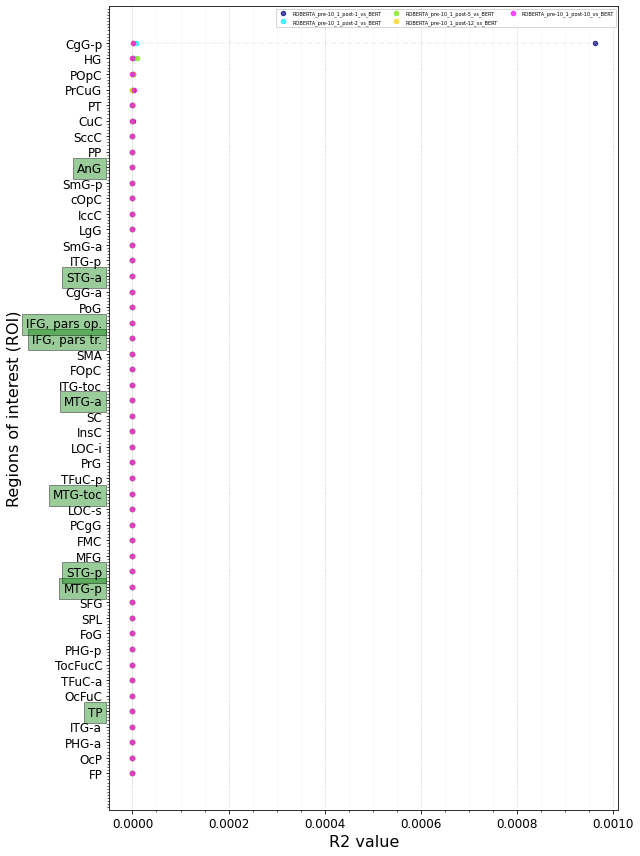

In [20]:
model_names = [
    'BERT_pre-10_1_post-0_vs_scaled',
    'BERT_pre-10_1_post-2_vs_scaled',
    'BERT_pre-10_1_post-5_vs_scaled',
    'BERT_pre-10_1_post-7_vs_scaled',
    'BERT_pre-10_1_post-10_vs_scaled'
              ]
model_names = ['ROBERTA_pre-10_1_post-1_vs_BERT' ,
    'ROBERTA_pre-10_1_post-2_vs_BERT',
    'ROBERTA_pre-10_1_post-5_vs_BERT',
    'ROBERTA_pre-10_1_post-12_vs_BERT',
    'ROBERTA_pre-10_1_post-10_vs_BERT']

legend_names = [
    'BERT_pre-10_1_post-0_vs_scaled',
    'BERT_pre-10_1_post-2_vs_scaled',
    'BERT_pre-10_1_post-5_vs_scaled',
    'BERT_pre-10_1_post-7_vs_scaled',
    'BERT_pre-10_1_post-10_vs_scaled'
               ]
legend_names = ['ROBERTA_pre-10_1_post-1_vs_BERT' ,
    'ROBERTA_pre-10_1_post-2_vs_BERT',
    'ROBERTA_pre-10_1_post-5_vs_BERT',
    'ROBERTA_pre-10_1_post-12_vs_BERT',
    'ROBERTA_pre-10_1_post-10_vs_BERT']


data_prep_vertical = reporting.get_data_per_roi(
                                data_model_comparison, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean = data_prep_vertical['mean']
third_quartile = data_prep_vertical['third_quartile']
maximum = data_prep_vertical['maximum']
reporting.vertical_plot(
                third_quartile, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='Model_comparison'
                )

########## ROBERTA_pre-10_1_post-1_vs_BERT ##########


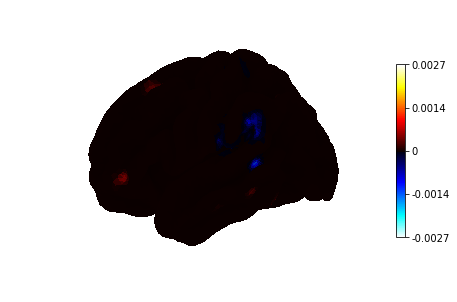

########## ROBERTA_pre-10_1_post-2_vs_BERT ##########


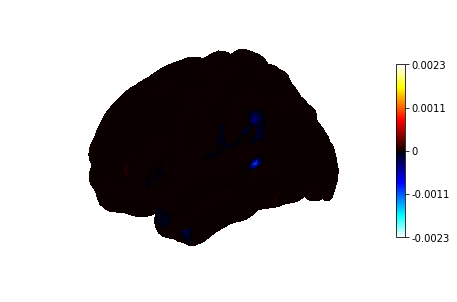

########## ROBERTA_pre-10_1_post-5_vs_BERT ##########


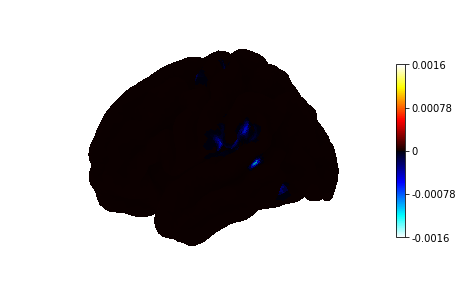

########## ROBERTA_pre-10_1_post-12_vs_BERT ##########


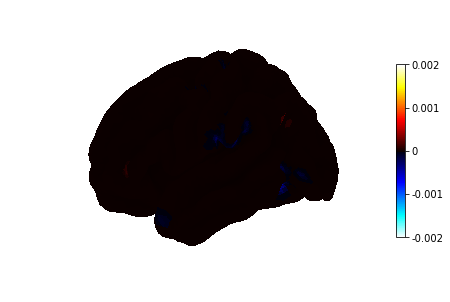

########## ROBERTA_pre-10_1_post-10_vs_BERT ##########


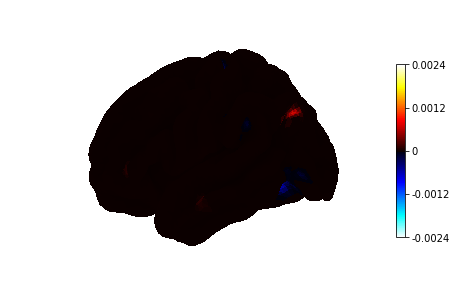

In [23]:
for index_comp, comparison in enumerate(comparisons):
    saving_path = os.path.dirname(paths[comparison])
    print("#"*10, comparison, "#"*10)
    reporting.plot_img_surf(paths[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.01, **kwargs)

### Surface plots

#### Surface plots showing which model predicts better (voxel-wise)

In [49]:
model_names = [
    'glove_300',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers',
    'gpt2_scaled_all-hidden-layers_pca_300',
    'bert-base-cased_old_all-hidden-layers_pca_300'
]

In [22]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}

In [51]:
img = reporting.get_voxel_wise_max_img_on_surf(
                            masker, 
                            model_names, 
                            language='english', 
                            PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/',
                            **kwargs
                            )

In [52]:
# saving_path = 

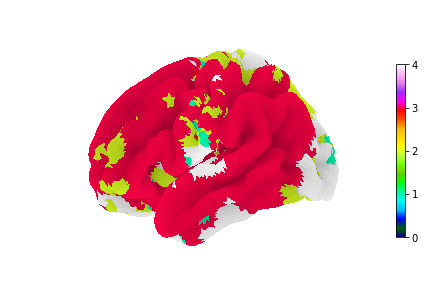

In [53]:
reporting.plot_roi_img_surf(img, saving_path=None, plot_name='model_comparison_surf', inflated=False, compute_surf=False, **kwargs)

In [23]:
view = reporting.interactive_surf_plot(img, inflated=False, **kwargs)
view

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
2

#### Surface plots of group-level difference analysis maps

In [54]:
comparisons = {
    'LSTM_300-H_vs_Glove' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'glove_300'],
    'BERT-Hpca_vs_GPT2-scaled-Hpca' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'gpt2_scaled_all-hidden-layers_pca_300'],
    'BERT-Hpca_vs_LSTM_300-H' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
    'GPT2-scaled-Hpca_vs_LSTM_300-H' : ['gpt2_scaled_all-hidden-layers_pca_300', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers'],
    'BERT-Hpca_vs_Glove' : ['bert-base-cased_old_all-hidden-layers_pca_300', 'glove_300'],
    'GPT2-scaled-Hpca_vs_Glove' : ['gpt2_scaled_all-hidden-layers_pca_300', 'glove_300']   
}

In [43]:
for comparison in comparisons:
    imgs_1 = data_full[comparisons[comparison][0]]['R2']
    imgs_2 = data_full[comparisons[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )

#####  LSTM_300-H-vs-Glove__R2  #####
#####  BERT-Hpca-vs-GPT2-scaled-Hpca__R2  #####
#####  BERT-Hpca-vs-LSTM_300-H__R2  #####
#####  GPT2-scaled-Hpca-vs-LSTM_300-H__R2  #####
#####  BERT-Hpca-vs-Glove__R2  #####
#####  GPT2-scaled-Hpca-vs-Glove__R2  #####


In [55]:
paths = {}
for comparison in comparisons:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

In [39]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.05
}

########## LSTM_300-H_vs_Glove ##########


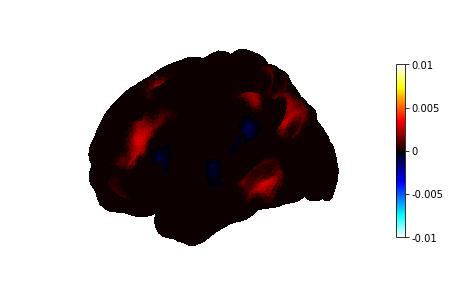

########## BERT-Hpca_vs_GPT2-scaled-Hpca ##########


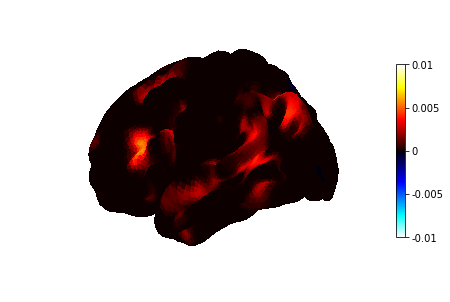

########## BERT-Hpca_vs_LSTM_300-H ##########


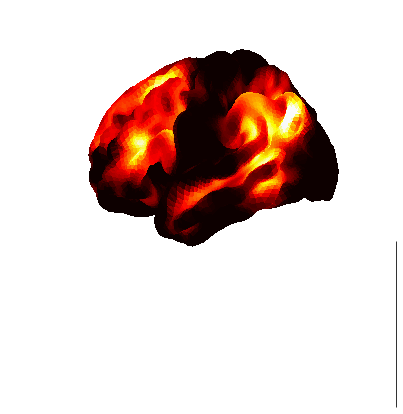

########## GPT2-scaled-Hpca_vs_LSTM_300-H ##########


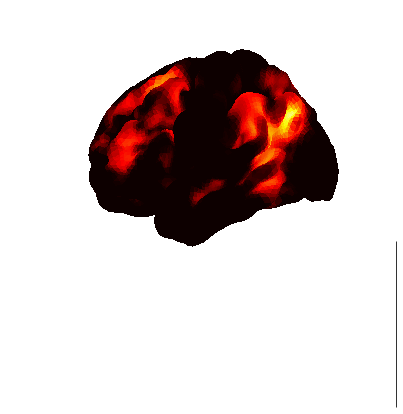

########## BERT-Hpca_vs_Glove ##########


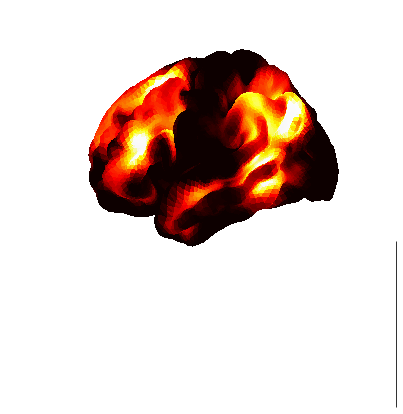

########## GPT2-scaled-Hpca_vs_Glove ##########


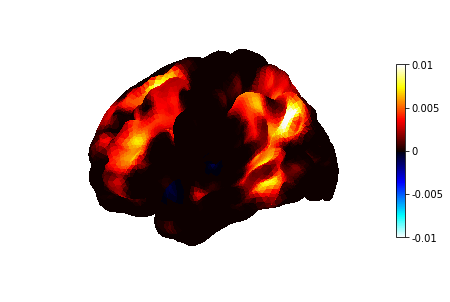

In [58]:
for index_comp, comparison in enumerate(comparisons):
    saving_path = os.path.dirname(paths[comparison])
    print("#"*10, comparison, "#"*10)
    plot_img_surf(paths[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.01, **kwargs)

## LSTM gates analysis

In [59]:
lstm_names = [
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-out-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-in-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-hidden-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-forget-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-c_tilde-layers',
    'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_{}_all-cell-layers'
]

lstm_legends = ['LSTM-E600-O300-L1', 
                'LSTM-E600-I300-L1', 
                'LSTM-E600-H300-L1',
                'LSTM-E600-F300-L1',
                'LSTM-E600-CT300-L1',
                'LSTM-E600-C300-L1'
               ]

Retrieving data and computing group level analysis:

In [60]:
data_lstm_gates = reporting.get_model_data(lstm_names, language, OUTPUT_PATH)
reporting.check_data(data_full, 51)
reporting.compute_t_test_for_model_comparison(
                                        data_lstm_gates, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

  4%|▍         | 2/51 [00:00<00:05,  8.46it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:06,  7.05it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:06,  7.14it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1


 14%|█▎        | 7/51 [00:00<00:05,  7.64it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1


 20%|█▉        | 10/51 [00:01<00:06,  6.79it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  7.85it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:03,  9.37it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 33%|███▎      | 17/51 [00:02<00:03,  8.78it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1


 41%|████      | 21/51 [00:02<00:03,  9.10it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02,  9.80it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 49%|████▉     | 25/51 [00:03<00:02,  8.84it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 57%|█████▋    | 29/51 [00:03<00:01, 11.11it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 61%|██████    | 31/51 [00:03<00:01, 11.08it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01,  9.90it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:04<00:02,  7.96it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1


 75%|███████▍  | 38/51 [00:04<00:01, 10.01it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00, 11.33it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00, 11.88it/s]

sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:04<00:00, 12.49it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1


100%|██████████| 51/51 [00:05<00:00,  9.52it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1



  4%|▍         | 2/51 [00:00<00:03, 16.27it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:05,  8.30it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:05,  8.71it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 20%|█▉        | 10/51 [00:00<00:03, 10.91it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1


 24%|██▎       | 12/51 [00:01<00:04,  9.12it/s]

sub-068 - 1 - 1
sub-069 - 1 - 1


 27%|██▋       | 14/51 [00:01<00:03,  9.60it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:03, 10.71it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 12.03it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:02<00:02, 12.90it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:02<00:02, 11.47it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1


 55%|█████▍    | 28/51 [00:02<00:01, 12.10it/s]

sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 12.33it/s]

sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1


 67%|██████▋   | 34/51 [00:03<00:01, 11.69it/s]

sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:03<00:01, 11.17it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1


 78%|███████▊  | 40/51 [00:03<00:01, 10.81it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 82%|████████▏ | 42/51 [00:03<00:00,  9.25it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 86%|████████▋ | 44/51 [00:04<00:00,  8.88it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 94%|█████████▍| 48/51 [00:04<00:00, 10.52it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1
sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1
sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1
sub-114 - 1 - 1
sub-115 - 1 - 1


  4%|▍         | 2/51 [00:00<00:03, 14.94it/s]

sub-057 - 1 - 1
sub-058 - 1 - 1
sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 12.16it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1


 16%|█▌        | 8/51 [00:00<00:03, 12.27it/s]

sub-064 - 1 - 1
sub-065 - 1 - 1
sub-066 - 1 - 1


 24%|██▎       | 12/51 [00:00<00:03, 12.86it/s]

sub-067 - 1 - 1
sub-068 - 1 - 1
sub-069 - 1 - 1


 29%|██▉       | 15/51 [00:01<00:02, 14.65it/s]

sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 37%|███▋      | 19/51 [00:01<00:02, 14.44it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:01<00:01, 14.65it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 55%|█████▍    | 28/51 [00:01<00:01, 16.22it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1
sub-087 - 1 - 1


 59%|█████▉    | 30/51 [00:02<00:01, 13.29it/s]

sub-088 - 1 - 1
sub-089 - 1 - 1


 63%|██████▎   | 32/51 [00:02<00:01, 12.46it/s]

sub-091 - 1 - 1
sub-092 - 1 - 1
sub-093 - 1 - 1


 69%|██████▊   | 35/51 [00:02<00:01, 14.25it/s]

sub-094 - 1 - 1
sub-095 - 1 - 1
sub-096 - 1 - 1


 76%|███████▋  | 39/51 [00:02<00:00, 12.19it/s]

sub-097 - 1 - 1
sub-098 - 1 - 1
sub-099 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 11.37it/s]

sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 12.26it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1
sub-108 - 1 - 1


 96%|█████████▌| 49/51 [00:03<00:00, 12.39it/s]

sub-109 - 1 - 1
sub-110 - 1 - 1
sub-113 - 1 - 1


  4%|▍         | 2/51 [00:00<00:02, 18.75it/s]

sub-114 - 1 - 1
sub-115 - 1 - 1
sub-057 - 1 - 1
sub-058 - 1 - 1


  8%|▊         | 4/51 [00:00<00:03, 15.12it/s]

sub-059 - 1 - 1
sub-061 - 1 - 1


 12%|█▏        | 6/51 [00:00<00:03, 14.12it/s]

sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1
sub-065 - 1 - 1


 22%|██▏       | 11/51 [00:00<00:02, 13.84it/s]

sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 27%|██▋       | 14/51 [00:00<00:02, 15.04it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1


 35%|███▌      | 18/51 [00:01<00:02, 14.53it/s]

sub-074 - 1 - 1
sub-075 - 1 - 1
sub-076 - 1 - 1


 39%|███▉      | 20/51 [00:01<00:02, 13.78it/s]

sub-077 - 1 - 1
sub-078 - 1 - 1
sub-079 - 1 - 1


 43%|████▎     | 22/51 [00:01<00:02, 13.92it/s]

sub-080 - 1 - 1
sub-081 - 1 - 1


 51%|█████     | 26/51 [00:01<00:01, 12.56it/s]

sub-082 - 1 - 1
sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 57%|█████▋    | 29/51 [00:02<00:01, 14.46it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 67%|██████▋   | 34/51 [00:02<00:01, 14.57it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1
sub-095 - 1 - 1


 71%|███████   | 36/51 [00:02<00:00, 15.28it/s]

sub-096 - 1 - 1
sub-097 - 1 - 1
sub-098 - 1 - 1


 80%|████████  | 41/51 [00:02<00:00, 12.93it/s]

sub-099 - 1 - 1
sub-100 - 1 - 1
sub-101 - 1 - 1


 88%|████████▊ | 45/51 [00:03<00:00, 13.48it/s]

sub-103 - 1 - 1
sub-104 - 1 - 1
sub-105 - 1 - 1
sub-106 - 1 - 1


 94%|█████████▍| 48/51 [00:03<00:00, 14.08it/s]

sub-108 - 1 - 1
sub-109 - 1 - 1
sub-110 - 1 - 1


 98%|█████████▊| 50/51 [00:03<00:00, 12.65it/s]

sub-113 - 1 - 1
sub-114 - 1 - 1


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 1 - 1


  2%|▏         | 1/51 [00:00<00:11,  4.31it/s]

sub-057 - 1 - 1


  4%|▍         | 2/51 [00:00<00:11,  4.10it/s]

sub-058 - 1 - 1


  6%|▌         | 3/51 [00:00<00:12,  3.91it/s]

sub-059 - 1 - 1


 12%|█▏        | 6/51 [00:01<00:11,  3.80it/s]

sub-061 - 1 - 1
sub-062 - 1 - 1
sub-063 - 1 - 1
sub-064 - 1 - 1


 22%|██▏       | 11/51 [00:01<00:06,  6.26it/s]

sub-065 - 1 - 1
sub-066 - 1 - 1
sub-067 - 1 - 1
sub-068 - 1 - 1


 29%|██▉       | 15/51 [00:02<00:03,  9.32it/s]

sub-069 - 1 - 1
sub-070 - 1 - 1
sub-072 - 1 - 1
sub-073 - 1 - 1
sub-074 - 1 - 1


 39%|███▉      | 20/51 [00:02<00:02, 12.05it/s]

sub-075 - 1 - 1
sub-076 - 1 - 1
sub-077 - 1 - 1
sub-078 - 1 - 1


 45%|████▌     | 23/51 [00:02<00:02, 12.72it/s]

sub-079 - 1 - 1
sub-080 - 1 - 1
sub-081 - 1 - 1
sub-082 - 1 - 1


 51%|█████     | 26/51 [00:02<00:01, 14.26it/s]

sub-083 - 1 - 1
sub-084 - 1 - 1
sub-086 - 1 - 1


 61%|██████    | 31/51 [00:02<00:01, 16.05it/s]

sub-087 - 1 - 1
sub-088 - 1 - 1
sub-089 - 1 - 1
sub-091 - 1 - 1


 65%|██████▍   | 33/51 [00:03<00:01, 14.86it/s]

sub-092 - 1 - 1
sub-093 - 1 - 1
sub-094 - 1 - 1


 73%|███████▎  | 37/51 [00:03<00:01, 13.68it/s]

sub-095 - 1 - 1
sub-096 - 1 - 1
sub-097 - 1 - 1


 76%|███████▋  | 39/51 [00:03<00:00, 14.16it/s]

sub-098 - 1 - 1
sub-099 - 1 - 1
sub-100 - 1 - 1


 80%|████████  | 41/51 [00:03<00:00, 13.97it/s]

sub-101 - 1 - 1
sub-103 - 1 - 1


 84%|████████▍ | 43/51 [00:04<00:00,  9.28it/s]

sub-104 - 1 - 1
sub-105 - 1 - 1


 88%|████████▊ | 45/51 [00:04<00:00,  6.06it/s]

sub-106 - 1 - 1


 90%|█████████ | 46/51 [00:04<00:00,  5.41it/s]

sub-108 - 1 - 1


 92%|█████████▏| 47/51 [00:05<00:00,  4.60it/s]

sub-109 - 1 - 1


 94%|█████████▍| 48/51 [00:05<00:00,  4.05it/s]

sub-110 - 1 - 1


 96%|█████████▌| 49/51 [00:05<00:00,  4.06it/s]

sub-113 - 1 - 1


 98%|█████████▊| 50/51 [00:05<00:00,  4.03it/s]

sub-114 - 1 - 1


100%|██████████| 51/51 [00:06<00:00,  8.11it/s]

sub-115 - 1 - 1
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers_R2  #####


#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers_Pearson_coeff  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-c_tilde-layers_R2  #####
#####  LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_eng

In [37]:
data_lstm_vertical = reporting.get_data_per_roi(
                                data_lstm_gates, 
                                atlas_maps,
                                labels,
                                analysis=None, 
                                language='english', 
                                PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                )
mean_lstm = data_lstm_vertical['mean']
third_quartile_lstm = data_lstm_vertical['third_quartile']

  0%|          | 0/48 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 48/48 [00:31<00:00,  1.53it/s]

		-->Done


/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/code/fMRI/reporting.py:319: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


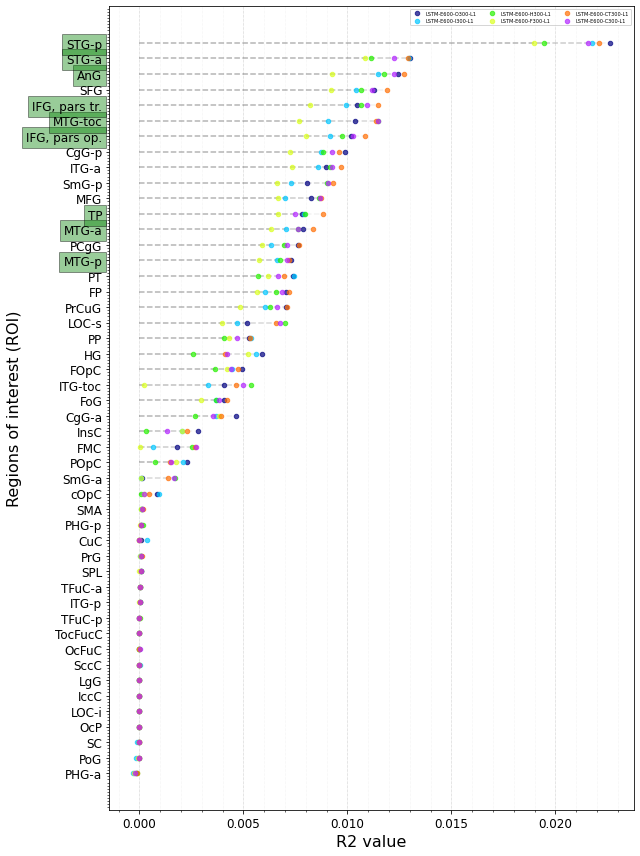

In [40]:
reporting.vertical_plot(
                third_quartile_lstm, 
                x_labels, 
                'Third_Quartile_R2_per_ROI',
                save_folder=None, 
                object_of_interest='R2', 
                surnames=load_surnames(),
                legend_names=lstm_legends, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,12), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='R2 value', 
                model_name='LSTM gates comparison'
                )

In [65]:
comparisons_lstm = {
    'LSTM-E600-I300-L1_vs_LSTM-E600-F300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-O300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-out-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-I300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-in-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-F300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-forget-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-C300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-cell-layers'],
    'LSTM-E600-H300-L1_vs_LSTM-E600-CT300-L1' : ['LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-hidden-layers', 'LSTM_embedding-size_600_nhid_300_nlayers_1_dropout_02_wiki_kristina_english_all-c_tilde-layers']
}
for comparison in comparisons_lstm:
    imgs_1 = data_lstm_gates[comparisons_lstm[comparison][0]]['R2']
    imgs_2 = data_lstm_gates[comparisons_lstm[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )

#####  LSTM-E600-I300-L1-vs-LSTM-E600-F300-L1__R2  #####
#####  LSTM-E600-H300-L1-vs-LSTM-E600-O300-L1__R2  #####
#####  LSTM-E600-H300-L1-vs-LSTM-E600-I300-L1__R2  #####


KeyboardInterrupt: 

In [66]:
paths_lstm = {}
for comparison in comparisons_lstm:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_lstm[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

########## LSTM-E600-I300-L1_vs_LSTM-E600-F300-L1 ##########


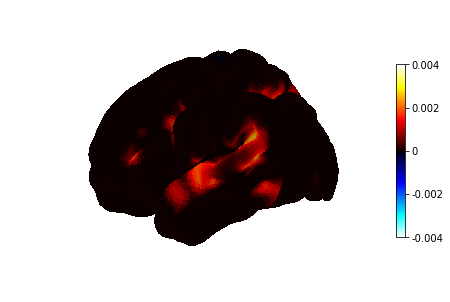

########## LSTM-E600-H300-L1_vs_LSTM-E600-O300-L1 ##########


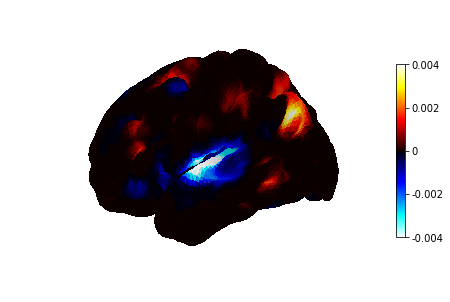

########## LSTM-E600-H300-L1_vs_LSTM-E600-I300-L1 ##########


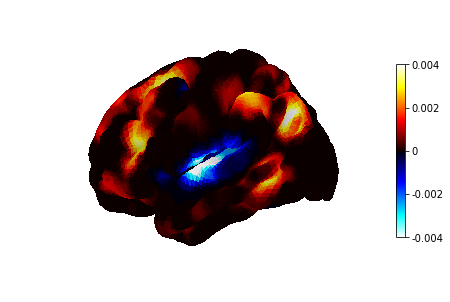

########## LSTM-E600-H300-L1_vs_LSTM-E600-F300-L1 ##########


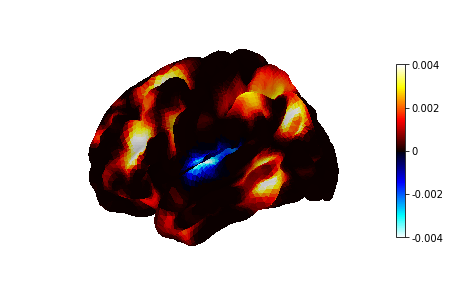

########## LSTM-E600-H300-L1_vs_LSTM-E600-C300-L1 ##########


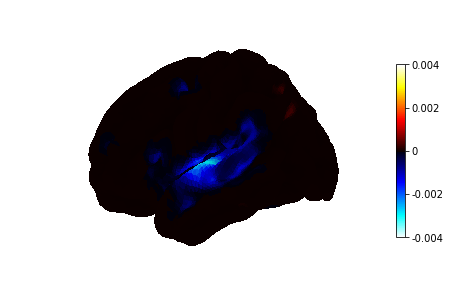

########## LSTM-E600-H300-L1_vs_LSTM-E600-CT300-L1 ##########


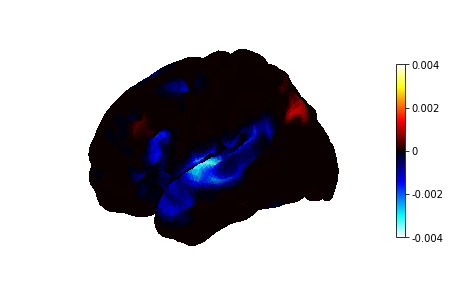

In [69]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}
for index_comp, comparison in enumerate(comparisons_lstm):
    saving_path = os.path.dirname(paths_lstm[comparison])
    print("#"*10, comparison, "#"*10)
    plot_img_surf(paths_lstm[comparison], saving_path=None, plot_name=comparison+'_surf', inflated=False, vmax=0.004, **kwargs)

## BERT vs GPT2

#### Comparison of Bert - Bert_seq - GPT2 with all hidden states of all layers

Here we compute group level maps for each model independently:

In [ ]:
big_model_names = [
    'gpt2_scaled_{}_all-hidden-layers',
    'bert-base-cased_{}_all-hidden-layers',
    'bert-base-cased_sequential_{}_all-hidden-layers'
]

big_model_legends = [
    'GPT2_scaled-H',
    'BERT-H',
    'Bert-seq-H'
]
data_big_models = reporting.get_model_data(big_model_names, language, OUTPUT_PATH)
reporting.check_data(data_big_models, 51)
reporting.compute_t_test_for_model_comparison(
                                        data_big_models, 
                                        smoothing_fwhm=6, 
                                        language='english',
                                        vmax=None,
                                        PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                        )

Here we compute group level maps of the difference between models:

In [ ]:
comparisons_big_models = {
    'BERT-H_vs_GPT2-scaled-H' : ['bert-base-cased_all-hidden-layers', 'gpt2_scaled_all-hidden-layers'],
    'BERT-H_vs_BERT-seq-H' : ['bert-base-cased_all-hidden-layers', 'bert-base-cased_sequential_all-hidden-layers'],
    'GPT2-scaled-H_vs_BERT-seq-H' : ['gpt2_scaled_all-hidden-layers', 'bert-base-cased_sequential_all-hidden-layers'],
}
for comparison in comparisons_big_models:
    imgs_1 = data_big_models[comparisons_big_models[comparison][0]]['R2']
    imgs_2 = data_big_models[comparisons_big_models[comparison][1]]['R2']
    
    names = comparison.split('_vs_')

    reporting.compute_model_contrasts_t_test(
                                    imgs_1,
                                    imgs_2,
                                    names[0], 
                                    names[1], 
                                    analysis_name='',
                                    observed_data='R2',
                                    language='english',
                                    smoothing_fwhm=6,
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
paths_big_models = {}
for comparison in comparisons_big_models:
    names = comparison.split('_vs_')
    name = '{}-vs-{}_{}'.format(names[0], names[1], '')
    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
    paths_big_models[comparison] = reporting.fetch_map(path, 'R2_group_fdr_effect')[0]

Surface plots:

In [ ]:
kwargs = {
    'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
    'surf_mesh_type': 'pial_left',
    'hemi':'left', # right
    'view':'lateral', # medial
    'bg_map': 'sulc_left', # sulc_right
    'bg_on_data':True,
    'darkness':.5
}
for index_comp, comparison in enumerate(comparisons_big_models):
    saving_path = os.path.dirname(paths_big_models[index_comp])
    plot_img_surf(paths_big_models[index_comp], saving_path=None, plot_name=comparison+'_surf', inflated=False, **kwargs):
        

#### Respective layer-wise analysis

In [ ]:
layer_analysis_model_names = [
    'gpt2_scaled',
    'bert-base-cased',
    'bert-base-cased_sequential'
]

In [ ]:
data_layers = get_layers_data(
                        layer_analysis_model_names, 
                        analysis=reporting.get_default_analysis(), 
                        language='english',
                        OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english/'
                        )

In [ ]:
for model_name in data_layers.keys():
    data_tmp_vertical = reporting.get_data_per_roi(
                                    data_layers, 
                                    atlas_maps,
                                    labels,
                                    analysis=reporting.get_default_analysis(),
                                    model_name=model_name,
                                    language='english', 
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
    mean_big_models = data_tmp_vertical['mean']
    third_quartile_big_models = data_tmp_vertical['third_quartile']
    reporting.vertical_plot(
                    third_quartile_big_models, 
                    x_labels, 
                    'Third_Quartile_R2_per_ROI',
                    save_folder=None, 
                    'R2', 
                    reporting.load_surnames(),
                    big_model_legends, 
                    reporting.load_syntactic_roi(), 
                    reporting.load_language_roi(), 
                    figsize=(9,12), 
                    count=False, 
                    title=None, 
                    ylabel='Regions of interest (ROI)', 
                    xlabel='R2 value', 
                    model_name='Model_comparison'
                    )

#### ROI surface plots 

The following surface plots indicate which layer predicts best which voxel.

In [ ]:
for model_name in data_layers.keys():
    for key in analysis:
        if key != 'Specific-attention-heads':
            maps = []
            for model in data[model_name][key].keys():
                if model == 'models':
                    models = data[model_name][key][model]
                else:
                    name = '_'.join([model_name, model])
                    path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/{}'.format(language, name))
                    name = 'R2_group_fdr_effect'
                    maps.append(fetch_map(path, name)[0])
            # Small reordering of models so that layers are in increasing order
            if key=='Hidden-layers':
                maps = maps[:2] + maps[5:] + maps[2:5]
                models = models[:2] + models[5:] + models[2:5]
                load = 0
            elif key=='Attention-layers':
                maps = maps[:1] + maps[4:] + maps[1:4]
                models = models[:1] + models[4:] + models[1:4]
                load = 1
            data_tmp = np.stack(masker.transform(map_) for map_ in maps)
            data_tmp = np.argmax(data_tmp, axis=0)
            data_tmp = (data_tmp + load)

            plot_name = "R2-{}-{}".format(model_name, key)

            img = masker.inverse_transform(data_tmp)

            saving_path = os.path.join(PROJECT_PATH, 'derivatives/fMRI/analysis/{}/glass_brains/'.format(language))
            check_folder(saving_path)
            print(plot_name)
            
            kwargs = {
                'surf_mesh': 'pial_left', # pial_right, infl_left, infl_right
                'surf_mesh_type': 'pial_left',
                'hemi':'left', # right
                'view':'lateral', # medial
                'bg_map': 'sulc_left', # sulc_right
                'bg_on_data':True,
                'darkness':.5
            }
            
            reporting.plot_roi_img_surf(img, saving_path=None, plot_name=model_name+'_surf', inflated=False, **kwargs)


#### Layer-wise analysis comparison (vertical plot)

In [ ]:
for model_name in data_layers.keys():
    data_tmp_vertical = reporting.get_data_per_roi(
                                    data_layers, 
                                    atlas_maps,
                                    labels,
                                    analysis=reporting.get_default_analysis(),
                                    model_name=model_name,
                                    language='english', 
                                    PROJECT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/'
                                    )
    mean_big_models = data_tmp_vertical['mean']
    third_quartile_big_models = data_tmp_vertical['third_quartile']
    reporting.vertical_plot(
                    third_quartile_big_models, 
                    x_labels, 
                    'Third_Quartile_R2_per_ROI',
                    save_folder=None, 
                    'R2', 
                    reporting.load_surnames(),
                    big_model_legends, 
                    reporting.load_syntactic_roi(), 
                    reporting.load_language_roi(), 
                    figsize=(9,12), 
                    count=False, 
                    title=None, 
                    ylabel='Regions of interest (ROI)', 
                    xlabel='R2 value', 
                    model_name='Model_comparison'
                    )